In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib import gridspec

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score,accuracy_score, recall_score, roc_auc_score, classification_report, confusion_matrix, roc_curve,precision_score

from imblearn.under_sampling import RandomUnderSampler

import math

## Loading the cleaned dataset

In [25]:
df = pd.read_csv("cleaned_heart_data.csv")

## Handling outlier

To handle outliers in the numeric variables (`MentalHealthDays`, `SleepHours`, `BMI`), we employ the **Min-Max Capping** strategy (also known as Winsorization) based on the Interquartile Range (IQR).

1.  **Calculate Bounds:** We first compute the IQR ($Q3 - Q1$) for each variable to establish statistical boundaries:
    * **Lower Bound:** $Q1 - 1.5 \times IQR$
    * **Upper Bound:** $Q3 + 1.5 \times IQR$

2.  **Capping Strategy:** Instead of removing data points that fall outside these bounds (which would result in data loss), we **cap** (clip) them to the nearest boundary:
    * Values **below the lower bound** are replaced with the *Lower Bound* value.
    * Values **above the upper bound** are replaced with the *Upper Bound* value.

* ***Reasons for this approach:***
    * It keeps the same number of observations in the dataset, preventing information loss from dropping rows.
    * It reduces the impact of extreme values (outliers) on model performance (e.g., Logistic Regression is sensitive to outliers) without completely ignoring the data point's directionality.

In [26]:
# Min-Max Outlier Capping for numeric variables
numeric_vars_to_cap = ['MentalHealthDays','SleepHours','BMI']

print("Min-Max Outlier Capping")
print("=" * 60)

# Ở trên t thấy có tính outlier, nên viết function để xuống đây gọi luôn cho dễ
for var in numeric_vars_to_cap:
    # Calculate IQR for outlier detection
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds (1.5*IQR method)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers before capping
    outliers_low = (df[var] < lower_bound).sum()
    outliers_high = (df[var] > upper_bound).sum()
    total_outliers = outliers_low + outliers_high
    
    print(f"\n{var}:")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  Outliers before: {total_outliers} ({total_outliers/len(df)*100:.2f}%)")
    print(f"    - Below lower bound: {outliers_low}")
    print(f"    - Above upper bound: {outliers_high}")
    
    # Apply capping
    df[var] = df[var].clip(lower=lower_bound, upper=upper_bound)
    
    print(f"  Range after capping: [{df[var].min():.2f}, {df[var].max():.2f}]")

print("\n" + "=" * 60)
print("Outlier capping completed!")

Min-Max Outlier Capping

MentalHealthDays:
  Q1: 0.00, Q3: 5.00, IQR: 5.00
  Bounds: [-7.50, 12.50]
  Outliers before: 62076 (13.95%)
    - Below lower bound: 0
    - Above upper bound: 62076
  Range after capping: [0.00, 12.50]

SleepHours:
  Q1: 6.00, Q3: 8.00, IQR: 2.00
  Bounds: [3.00, 11.00]
  Outliers before: 7273 (1.63%)
    - Below lower bound: 2704
    - Above upper bound: 4569
  Range after capping: [3.00, 11.00]

BMI:
  Q1: 24.41, Q3: 31.09, IQR: 6.68
  Bounds: [14.39, 41.11]
  Outliers before: 18826 (4.23%)
    - Below lower bound: 425
    - Above upper bound: 18401
  Range after capping: [14.39, 41.11]

Outlier capping completed!


# I. Analyze the questions


---

### **Question 1: The Mind–Body connection and sleep**

**1. The Question**  
> *"How do mental health (MentalHealthDays) and sleep duration (SleepHours) interact in relation to Heart Attack risk? Does physical activity (PhysicalActivities) act as a protective factor that mitigates cardiovascular risk in individuals with poor sleep or psychological stress?"*

**2. Motivation & Benefits**
* **Motivation:** Sleep and stress are often overlooked lifestyle factors compared to diet or smoking. This question tests the hypothesis that *exercise can compensate for stress or sleep deprivation*.
* **Benefits:** Enables concrete lifestyle recommendations (e.g., “If you experience insomnia, engaging in physical activity may help reduce cardiovascular risk”).
* **Stakeholders:** Mental health counselors, Health and fitness coaches.

**3. Data analysis**

* **A. Preprocessing:**
  * Bin `SleepHours` into categories: “Sleep Deprived” (<6h), “Normal” (6–8h), “Long Sleep” (>8h).
  * Group `MentalHealthDays` into: “Good” (0 days), “Moderate” (1–13 days), “Poor” (≥14 days).

In [3]:
# Copy dataframe
df_q1 = df.copy() 

# Function to bin Sleep
def bin_sleep(hours):
    if hours < 6: return '1. Low (<6h)'
    elif 6 <= hours <= 8: return '2. Normal (6-8h)'
    else: return '3. High (>8h)'

# Function to bin Mental Health
def bin_mental(days):
    if days == 0: return '1. Good (0 days)'
    elif 1 <= days <= 13: return '2. Moderate (1-13 days)'
    else: return '3. Poor (14+ days)'

* **B. Analysis:**
  * Conduct multivariate analysis to assess how Heart Attack risk varies across the combination of Sleep, Mental Health, and Physical Activity.

In [4]:
df_q1['Sleep_Group'] = df_q1['SleepHours'].apply(bin_sleep)
df_q1['Mental_Group'] = df_q1['MentalHealthDays'].apply(bin_mental)
# Scenario A: Inactive People
heatmap_inactive = df_q1[df_q1['PhysicalActivities'] == 'No'].pivot_table(
    index='Mental_Group', columns='Sleep_Group', values='HadHeartAttack', 
    aggfunc=lambda x: (x == 'Yes').mean() * 100 )

# Scenario B: Active People
heatmap_active = df_q1[df_q1['PhysicalActivities'] == 'Yes'].pivot_table(
    index='Mental_Group', columns='Sleep_Group', values='HadHeartAttack', 
    aggfunc=lambda x: (x == 'Yes').mean() * 100 )

* **C. Visualization:**
  * **Heatmap:** X-axis = Sleep groups, Y-axis = Mental Health groups, color intensity = Heart Attack rate.  
    Plot two separate heatmaps: one for individuals who exercise and one for those who do not, to highlight the difference (Delta).

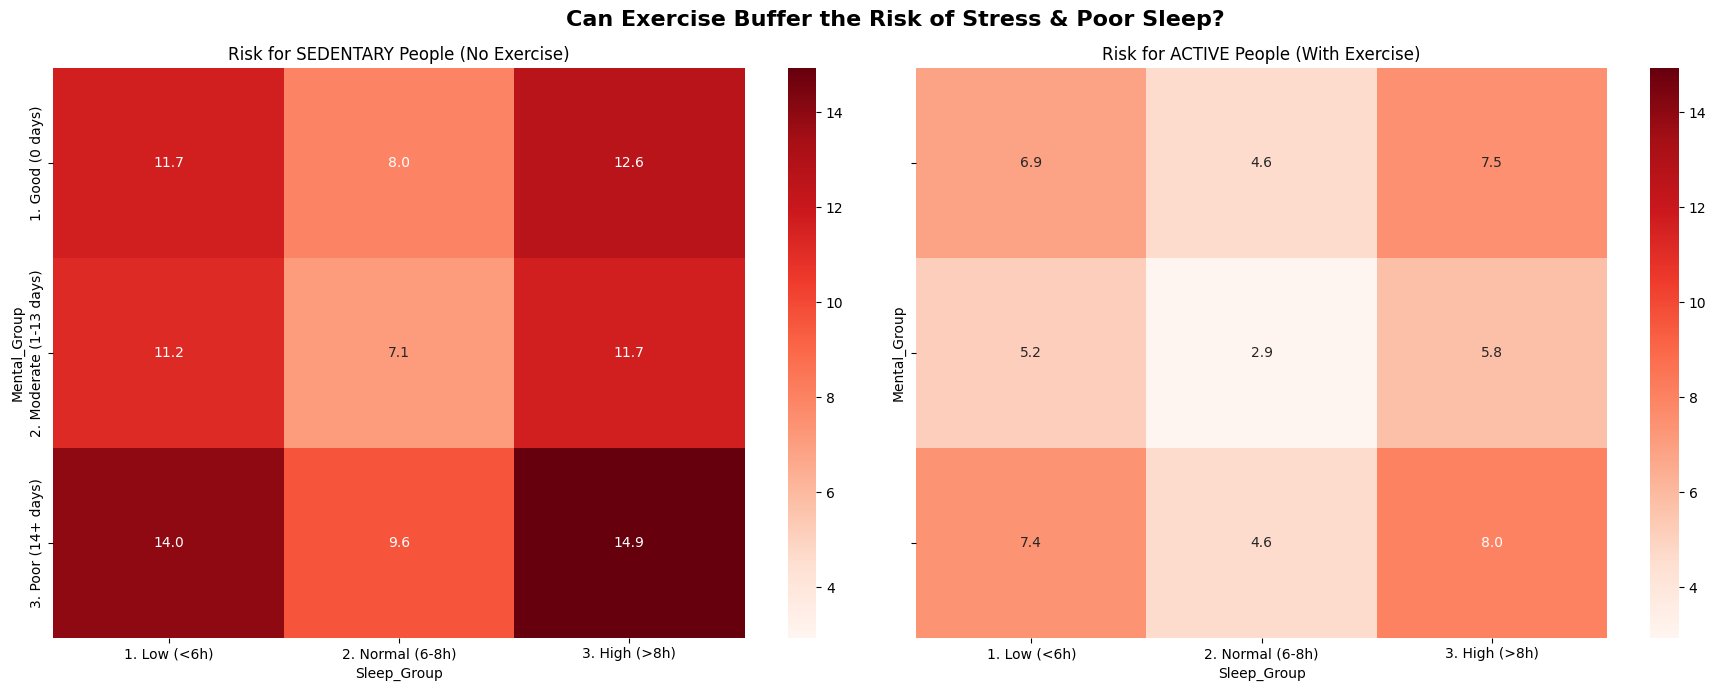

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# Find global min/max to ensure colors are comparable
vmin = min(heatmap_inactive.min().min(), heatmap_active.min().min())
vmax = max(heatmap_inactive.max().max(), heatmap_active.max().max())

# Plot Inactive
sns.heatmap(heatmap_inactive, ax=axes[0], annot=True, fmt=".1f", cmap='Reds', vmin=vmin, vmax=vmax)
axes[0].set_title('Risk for SEDENTARY People (No Exercise)')

# Plot Active
sns.heatmap(heatmap_active, ax=axes[1], annot=True, fmt=".1f", cmap='Reds', vmin=vmin, vmax=vmax)
axes[1].set_title('Risk for ACTIVE People (With Exercise)')

plt.suptitle('Can Exercise Buffer the Risk of Stress & Poor Sleep?', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

**4. Insights**

The visualization compares heart disease risk between **Sedentary** (Left) and **Active** (Right) individuals across different Mental Health and Sleep conditions.

* **Insight 1: Exercise is a potential shield**
    * The most striking finding is that `active individuals have significantly lower cardiovascular risk across the board`, regardless of their sleep quality or mental state.
    
    * An active person with the *worst* conditions (Poor Mental Health + High Sleep) has a risk of **8.0%**. This is roughly equivalent to or better than a sedentary person with the *best* conditions (Good Mental Health + Normal Sleep), who sits at **8.0%**. This suggests that physical activity may outweigh the negative impacts of moderate stress or irregular sleep.


* **Insight 2: The "U-Shaped" Sleep Curve**
    * In both groups, `Normal Sleep (6-8h)` is the "sweet spot" for heart health (the center column is consistently the lightest color).
    
    * Both `Low Sleep (<6h)` and `High Sleep (>8h)` are associated with increased risk.
    
    &rarr; From the plot, we can see an example that risk jumps from **9.6%** (Normal Sleep) to **14.0%** (Low Sleep) and **14.9%** (High Sleep) for those with poor mental health.


* **Insight 3: The compound effect of Stress and Inactivity**
    * The highest risk in the entire dataset (**14.9%**) is found in sedentary people with `poor Mental Health` and `High Sleep (>8h)`. Conversely, the lowest risk (**2.9%**) is found in active people with `moderate Mental Health` and `Normal Sleep`.

    &rarr; This highlights a "double penalty": if you are sedentary, the added burden of poor mental health and poor sleep creates a dangerously high probability of heart issues.

* **Insight 4: Mental Health gradient**
    * Generally, as we move down the rows from "Good" to "Poor" mental health, the risk increases, particularly in the Sedentary group. However, for Active people, the risk difference between "Good" and "Poor" mental health is much narrower (e.g., varying only between 4.6% and 8.0%), further proving that exercise stabilizes health outcomes against psychological stress.

**5. Answer to each part of the Question 1**

**P1: How do mental health and sleep duration interact regarding Heart Attack risk?**
**A:** There is a clear interaction: Poor mental health exacerbates the risks associated with poor sleep. When a person is mentally stressed *and* sleeping poorly (either too little or too much), their heart attack risk spikes. However, the data shows that sleep duration is a critical baseline—regardless of your mental state, deviating from the 6-8 hour "normal" window consistently harms heart health.

**P2: Does physical activity act as a protective factor?**
**A:** **Yes, emphatically.**
From a human perspective, this data offers a powerful message of hope: `You cannot always control your stress levels or cure insomnia overnight, but you can control your movement.` The data shows that physical activity acts as a "shield." Even if you are going through a period of deep depression (Poor Mental Health) and sleeping terribly, being physically active keeps your heart risk (**~7-8%**) roughly the same as a sedentary person who is perfectly happy and sleeping well. Exercise essentially "buys you a pass," mitigating the physical damage that stress and sleep deprivation would otherwise cause to your cardiovascular system.

---


### **Question 2: The Compounding Effect of Multimorbidity**

**1. The Question**  
> *"How does the risk of Heart Attack (HadHeartAttack) change as an individual suffers from multiple chronic conditions simultaneously (Diabetes, Kidney Disease, COPD, Asthma, etc.)? Is this disease burden more impactful in younger age groups (lower AgeCategory) compared to older ones?"*

**2. Motivation & benefits**
* **Motivation:** Most studies examine chronic diseases individually. However, in real-world settings, patients often suffer from multiple conditions at the same time. Quantifying the overall "disease burden" provides deeper insight into cumulative health deterioration.
* **Benefits:** Helps clinicians prioritize resources for patients with the most dangerous disease combinations, especially among younger individuals—where cardiovascular risk is often underestimated.
* **Stakeholders:** General practitioners, Preventive medicine specialists.

**3. Data Analysis Plan**

* **A. Preprocessing:**
  * Create a new numerical variable `Comorbidity_Score`: the total number of chronic diseases per individual (summing `HadDiabetes`, `HadKidneyDisease`, `HadArthritis`, `HadCOPD`, `HadAsthma`, `HadDepressiveDisorder` after binary encoding 0/1).
  * Encode `AgeCategory` into an ordinal numeric format for trend visualization.

In [6]:
columns_analysis = ['HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder',
                'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'HadAngina', 'HadStroke']
target_column = 'HadHeartAttack'
categorical = ['AgeCategory']

df_q1 = df[columns_analysis + [target_column] + categorical].copy()

# Binary encoding: convert 'Yes'/'No' to 1/0
for col in columns_analysis + [target_column]:
    df_q1[col] = (df_q1[col] == 'Yes').astype(int)

# Calculate comorbidity score
df_q1['Comorbidity_Score'] = df_q1[columns_analysis].sum(axis=1)

* **B. Analysis:**

  * Use GroupBy to calculate the percentage of `HadHeartAttack` for each `Comorbidity_Score` level (0 diseases, 1 disease, 2 diseases, 3+ diseases).

In [7]:
# Group by hadHeartAttack and Comrbidity_Score
heart_attack_cases = df_q1[df_q1['HadHeartAttack']== 1]
#Get total rows
total_records = heart_attack_cases.shape[0]
score_stats = heart_attack_cases.groupby('Comorbidity_Score', observed=False)['HadHeartAttack'].count().reset_index()
score_stats['Percentage_of_Total'] = (score_stats['HadHeartAttack'] / total_records) * 100
score_stats

,Comorbidity_Score,HadHeartAttack,Percentage_of_Total
0,0,2156,8.445298
1,1,4981,19.511144
2,2,6128,24.004074
3,3,5215,20.427749
4,4,3614,14.156450
5,5,2032,7.959575
6,6,962,3.768264
7,7,324,1.269145
8,8,91,0.356457
9,9,26,0.101845


* Use Pivot table to perform stratified analysis by `AgeCategory` to examine differences in risk gradients.

In [9]:
# Analyze by AgeCategoryummary_stats
age_group_stats = heart_attack_cases.groupby(['AgeCategory', 'Comorbidity_Score'], observed=False)['HadHeartAttack'].count().reset_index()
age_group_totals = heart_attack_cases.groupby('AgeCategory', observed=False)['HadHeartAttack'].count().reset_index()
age_group_summary = pd.merge(age_group_stats, age_group_totals, on='AgeCategory', suffixes=('_Count', '_Total'))
age_group_summary['Percentage_of_Total'] = (age_group_summary['HadHeartAttack_Count'] / age_group_summary['HadHeartAttack_Total']) * 100
age_group_summary

pivot_table = age_group_summary.pivot(index='Comorbidity_Score', columns='AgeCategory', values='Percentage_of_Total').fillna(0)
pivot_table

AgeCategory,Age 18 to 24,Age 25 to 29,Age 30 to 34,Age 35 to 39,Age 40 to 44,Age 45 to 49,Age 50 to 54,Age 55 to 59,Age 60 to 64,Age 65 to 69,Age 70 to 74,Age 75 to 79,Age 80 or older
Comorbidity_Score,,,,,,,,,,,,,
0,27.692308,32.539683,20.812183,20.489297,15.367965,11.497326,12.064965,9.316155,8.678238,7.611823,7.085531,6.489525,6.934164
1,26.923077,20.634921,24.873096,25.076453,24.458874,18.850267,20.030936,19.375619,19.259012,18.964164,18.803027,18.369954,20.335021
2,18.461538,15.873016,26.395939,21.100917,22.943723,25.668449,20.262954,21.258672,22.930574,24.064871,24.604449,23.735309,26.587456
3,12.307692,11.904762,12.182741,12.844037,14.069264,17.647059,16.627997,18.533201,20.093458,19.434999,21.256593,23.071027,22.536034
4,3.846154,7.936508,9.644670,8.256881,12.554113,12.967914,16.163960,16.055500,14.285714,15.459064,14.400367,14.512008,12.660693
5,3.076923,7.936508,4.060914,6.116208,5.627706,6.951872,10.131477,8.870168,8.544726,8.108815,8.025682,8.124681,7.167900
6,1.538462,2.380952,1.522843,3.058104,3.463203,4.946524,3.093581,4.608523,4.439252,4.054408,4.035772,3.985692,2.687963
7,1.538462,0.000000,0.507614,1.529052,0.865801,0.802139,1.237432,1.585728,1.268358,1.726393,1.467553,1.277466,0.779120
8,2.307692,0.000000,0.000000,0.611621,0.649351,0.534759,0.386698,0.297324,0.400534,0.418519,0.275166,0.383240,0.253214


* **C. Visualization:**

* Visualize the percentage of `HadHeartAttack` for each `Comorbidity_Score` level (0 diseases, 1 disease, 2 diseases, 3+ diseases).
    * Pie chart
    * Bar chart

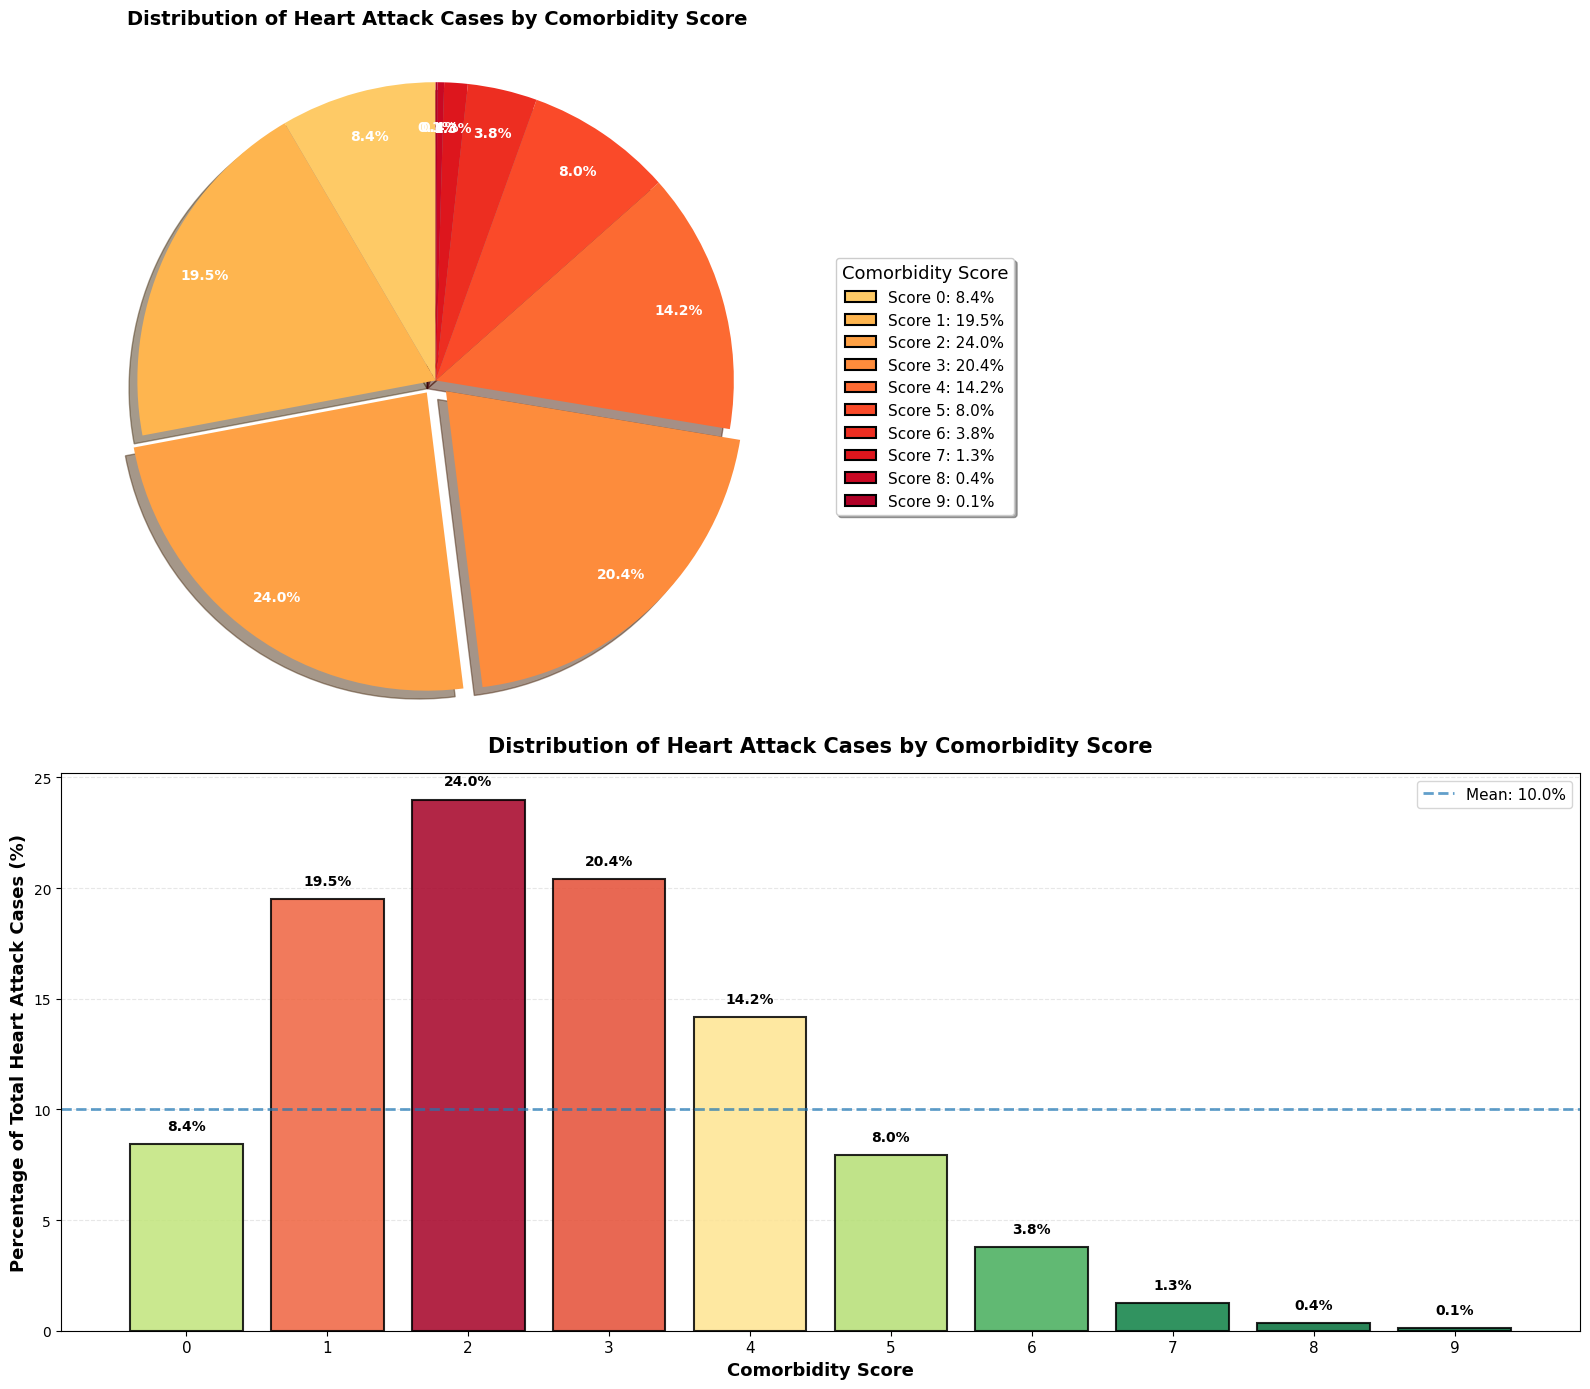

In [ ]:
labels = score_stats['Comorbidity_Score']
sizes = score_stats['Percentage_of_Total']

# Color palettes
colors_pie = plt.cm.YlOrRd(np.linspace(0.3, 0.9, len(labels)))
colors_grad = plt.cm.RdYlGn_r(sizes / sizes.max())

fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(2, 2, height_ratios=[1.2, 1])

# Pie chart
ax1 = fig.add_subplot(gs[0, 0])

wedges, texts, autotexts = ax1.pie(
    sizes,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_pie,
    pctdistance=0.85,
    explode=[0.05 if i in [2, 3] else 0 for i in range(len(labels))],
    shadow=True,
    textprops={'fontsize': 11, 'weight': 'bold'}
)

ax1.set_title(
    'Distribution of Heart Attack Cases by Comorbidity Score',
    fontsize=14,
    fontweight='bold',
    pad=20
)

for autotext in autotexts:
    autotext.set_weight('bold')
    autotext.set_color('white')
    autotext.set_fontsize(10)

ax1.axis('equal')

ax2 = fig.add_subplot(gs[0, 1])
ax2.axis('off')

legend_elements = [
    Rectangle((0, 0), 1, 1, fc=color, edgecolor='black', linewidth=1.5)
    for color in colors_pie
]

legend_labels = [
    f'Score {int(l)}: {sizes.iloc[i]:.1f}%'
    for i, l in enumerate(labels)
]

ax2.legend(
    legend_elements,
    legend_labels,
    loc='center left',
    title='Comorbidity Score',
    title_fontsize=13,
    fontsize=11,
    frameon=True,
    shadow=True,
    fancybox=True
)

# Bar chart
ax3 = fig.add_subplot(gs[1, :])

bars = ax3.bar(
    labels,
    sizes,
    color=colors_grad,
    edgecolor='black',
    linewidth=1.5,
    alpha=0.85
)

ax3.set_xlabel('Comorbidity Score', fontsize=13, fontweight='bold')
ax3.set_ylabel('Percentage of Total Heart Attack Cases (%)', fontsize=13, fontweight='bold')
ax3.set_title(
    'Distribution of Heart Attack Cases by Comorbidity Score',
    fontsize=15,
    fontweight='bold',
    pad=15
)

ax3.set_xticks(labels)
ax3.set_xticklabels([f'{int(l)}' for l in labels], fontsize=11)
ax3.grid(axis='y', linestyle='--', alpha=0.3)
ax3.set_axisbelow(True)

mean_val = sizes.mean()
ax3.axhline(
    y=mean_val,
    linestyle='--',
    linewidth=2,
    alpha=0.7,
    label=f'Mean: {mean_val:.1f}%'
)

for bar, val in zip(bars, sizes):
    ax3.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,
        f'{val:.1f}%',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

ax3.legend(fontsize=11)

plt.tight_layout()
plt.show()


### **Insights from the plots**

* **Insight 1: The "Critical Window" of Multimorbidity (Scores 1-3)**

    * Contrary to the assumption that heart attacks primarily strike those who are "extremely sick" with every possible disease, the data reveals that nearly 64% of all heart attack cases occur in individuals with just **1 to 3 comorbidities**.

    * The highest concentration of cases is at **Score 2 (24.0%)**, followed closely by **Score 3 (20.4%)** and **Score 1 (19.5%)**. This suggests that the "tipping point" for cardiovascular failure often comes earlier in the disease accumulation process than expected. Theoretically, there are some chronic conditions like `HadAsthma` or `HadDiabetes` that related directly to HeartDisease; which means the chance that people having these symptions are almost `60%` and it explains why **Score 1** seems so high in these plots. 


* **Insight 2: The "Silent" Threat (Zero Comorbidities)**

    * A significant portion of heart attack cases (**8.4%**) occurred in individuals with **Score 0**—meaning they had *no* other recorded chronic conditions (no diabetes, asthma, kidney disease, etc.).

    * This is a crucial insight for preventive medicine: a clean bill of health regarding chronic diseases does not guarantee immunity. Other factors (likely stress, genetics, or acute lifestyle factors discussed in Question 1) are driving nearly 1 in 12 heart attacks.


* **Insight 3: The Rarity of Extreme Multimorbidity**
    * The distribution tail (Scores 7, 8, 9) accounts for a tiny fraction of cases (e.g., Score 9 is only **0.1%**).

    * This does not necessarily mean risk decreases at high scores. Rather, it likely implies that very few people in the general population survive long enough to acquire 7+ concurrent chronic conditions, or the sample size for this group is simply much smaller. The public health battleground is clearly in the moderate range (Scores 1-4), not the extreme range.

* Visualize stratified analysis by `AgeCategory` using:
    * Line graph
    * Bar chart

## Line graph

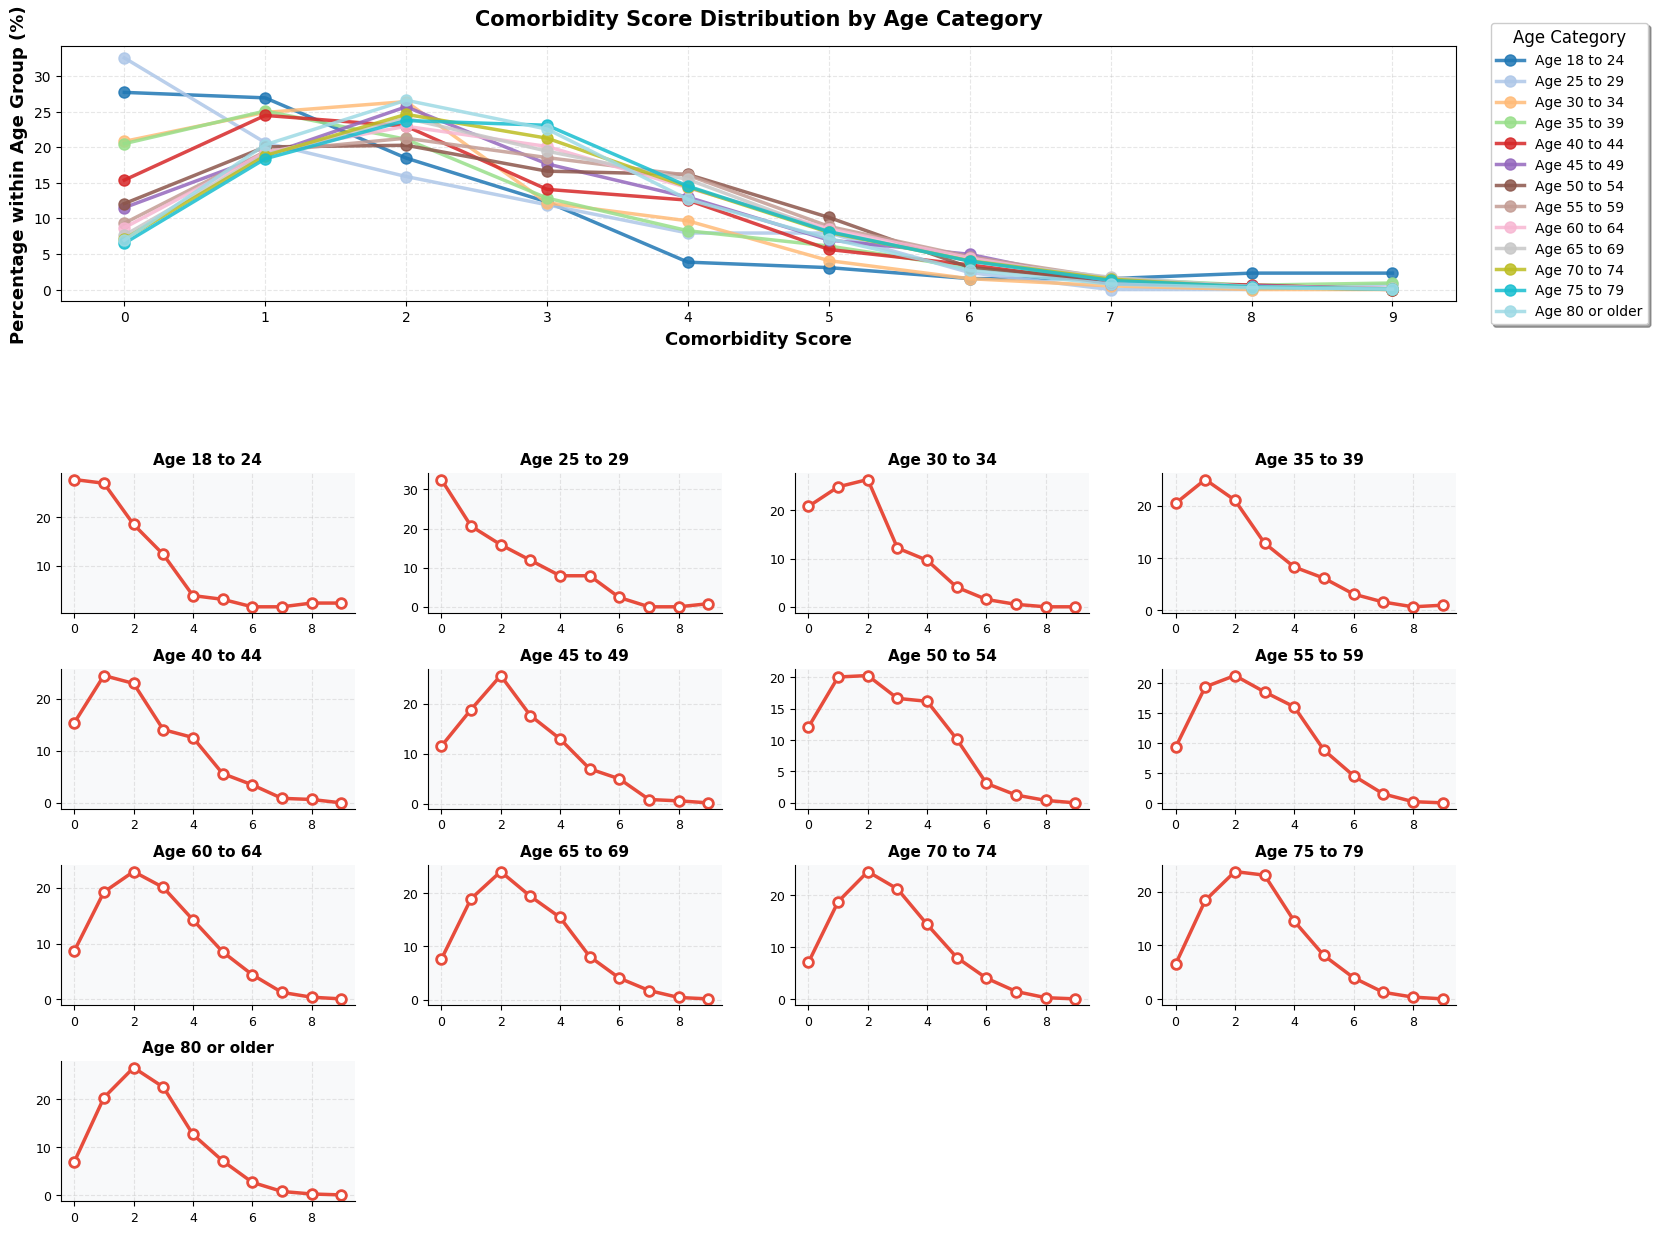

In [ ]:
age_categories = pivot_table.columns.tolist()
n = len(age_categories)

colors_palette = plt.cm.tab20(np.linspace(0, 1, n))
color_main = '#e74c3c'

cols = 4
rows = math.ceil(n / cols)

fig = plt.figure(figsize=(18, 15), constrained_layout=True)

gs = gridspec.GridSpec(
    2, 1,
    height_ratios=[1.4, rows],  # top plot dominates
    hspace=0.35
)

# Line graph with all age categories
ax = fig.add_subplot(gs[0])

for idx, age in enumerate(age_categories):
    ax.plot(
        pivot_table.index,
        pivot_table[age],
        marker='o',
        linewidth=2.5,
        markersize=8,
        label=age,
        color=colors_palette[idx],
        alpha=0.85
    )

ax.set_xlabel('Comorbidity Score', fontsize=13, fontweight='bold')
ax.set_ylabel('Percentage within Age Group (%)', fontsize=13, fontweight='bold')
ax.set_title(
    'Comorbidity Score Distribution by Age Category',
    fontsize=15,
    fontweight='bold',
    pad=15
)

ax.set_xticks(range(10))
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Legend INSIDE axis (key fix)
ax.legend(
    title='Age Category',
    title_fontsize=12,
    fontsize=10,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=True,
    shadow=True,
    fancybox=True
)

# Individual subplots for each age category
gs_bottom = gridspec.GridSpecFromSubplotSpec(
    rows, cols,
    subplot_spec=gs[1],
    hspace=0.4,
    wspace=0.25
)

for i, age in enumerate(age_categories):
    ax_s = fig.add_subplot(gs_bottom[i])

    ax_s.plot(
        pivot_table.index,
        pivot_table[age],
        marker='o',
        linewidth=2.5,
        markersize=7,
        color=color_main,
        markerfacecolor='white',
        markeredgewidth=2,
        markeredgecolor=color_main
    )

    ax_s.set_title(age, fontsize=11, fontweight='bold', pad=6)
    ax_s.set_xticks(range(0, 10, 2))
    ax_s.grid(True, linestyle='--', alpha=0.3)
    ax_s.set_axisbelow(True)
    ax_s.tick_params(labelsize=9)

    ax_s.set_facecolor('#f8f9fa')
    ax_s.spines['top'].set_visible(False)
    ax_s.spines['right'].set_visible(False)

# Hide unused subplots
for j in range(i + 1, rows * cols):
    fig.add_subplot(gs_bottom[j]).axis('off')

plt.show()


### **Insights on trends**

* **Trend 1: The "Rightward Shift" of disease burden**
There is a clear, continuous "wave" visible in the line charts. As we move from the youngest age groups (blue lines) to the oldest (orange/red lines), the peak of the curve shifts distinctly to the right.
    * **Young Adults (18–29):** The trend is heavily skewed to the left. The highest percentage of individuals in this group have **Score 0** (approx. 28-32%). This indicates that for young people, heart risks are likely "acute" or genetic rather than driven by accumulated organ failure.
    * **The Transition (40–54):** The curve flattens. By age 40-44, the dominance of "Score 0" vanishes, and the population is evenly distributed between Scores 1 and 2.
    * **Seniors (65+):** The trend establishes a "new normal." The peak sits firmly at **Score 2 (approx. 24%)**, with a significant "fat tail" extending to Scores 3 and 4.


* **Trend 2: The "Ceiling Effect" of Survival**
    * Interestingly, the trend does *not* continue linearly into extreme multimorbidity. We can see that in the young age **(18 - 29)**, the trend starts from a very high percentage but drops continously by the cormodity level. However, in the older group, the curve peaks at Score 2 and drops off sharply after Score 4.
    * This suggests a "biological ceiling." Patients likely do not survive long enough to accumulate 7, 8, or 9 concurrent chronic conditions. The mortality risk becomes too high before they reach that stage, making Scores 7-9 statistical rarities regardless of age.

##  Bar chart

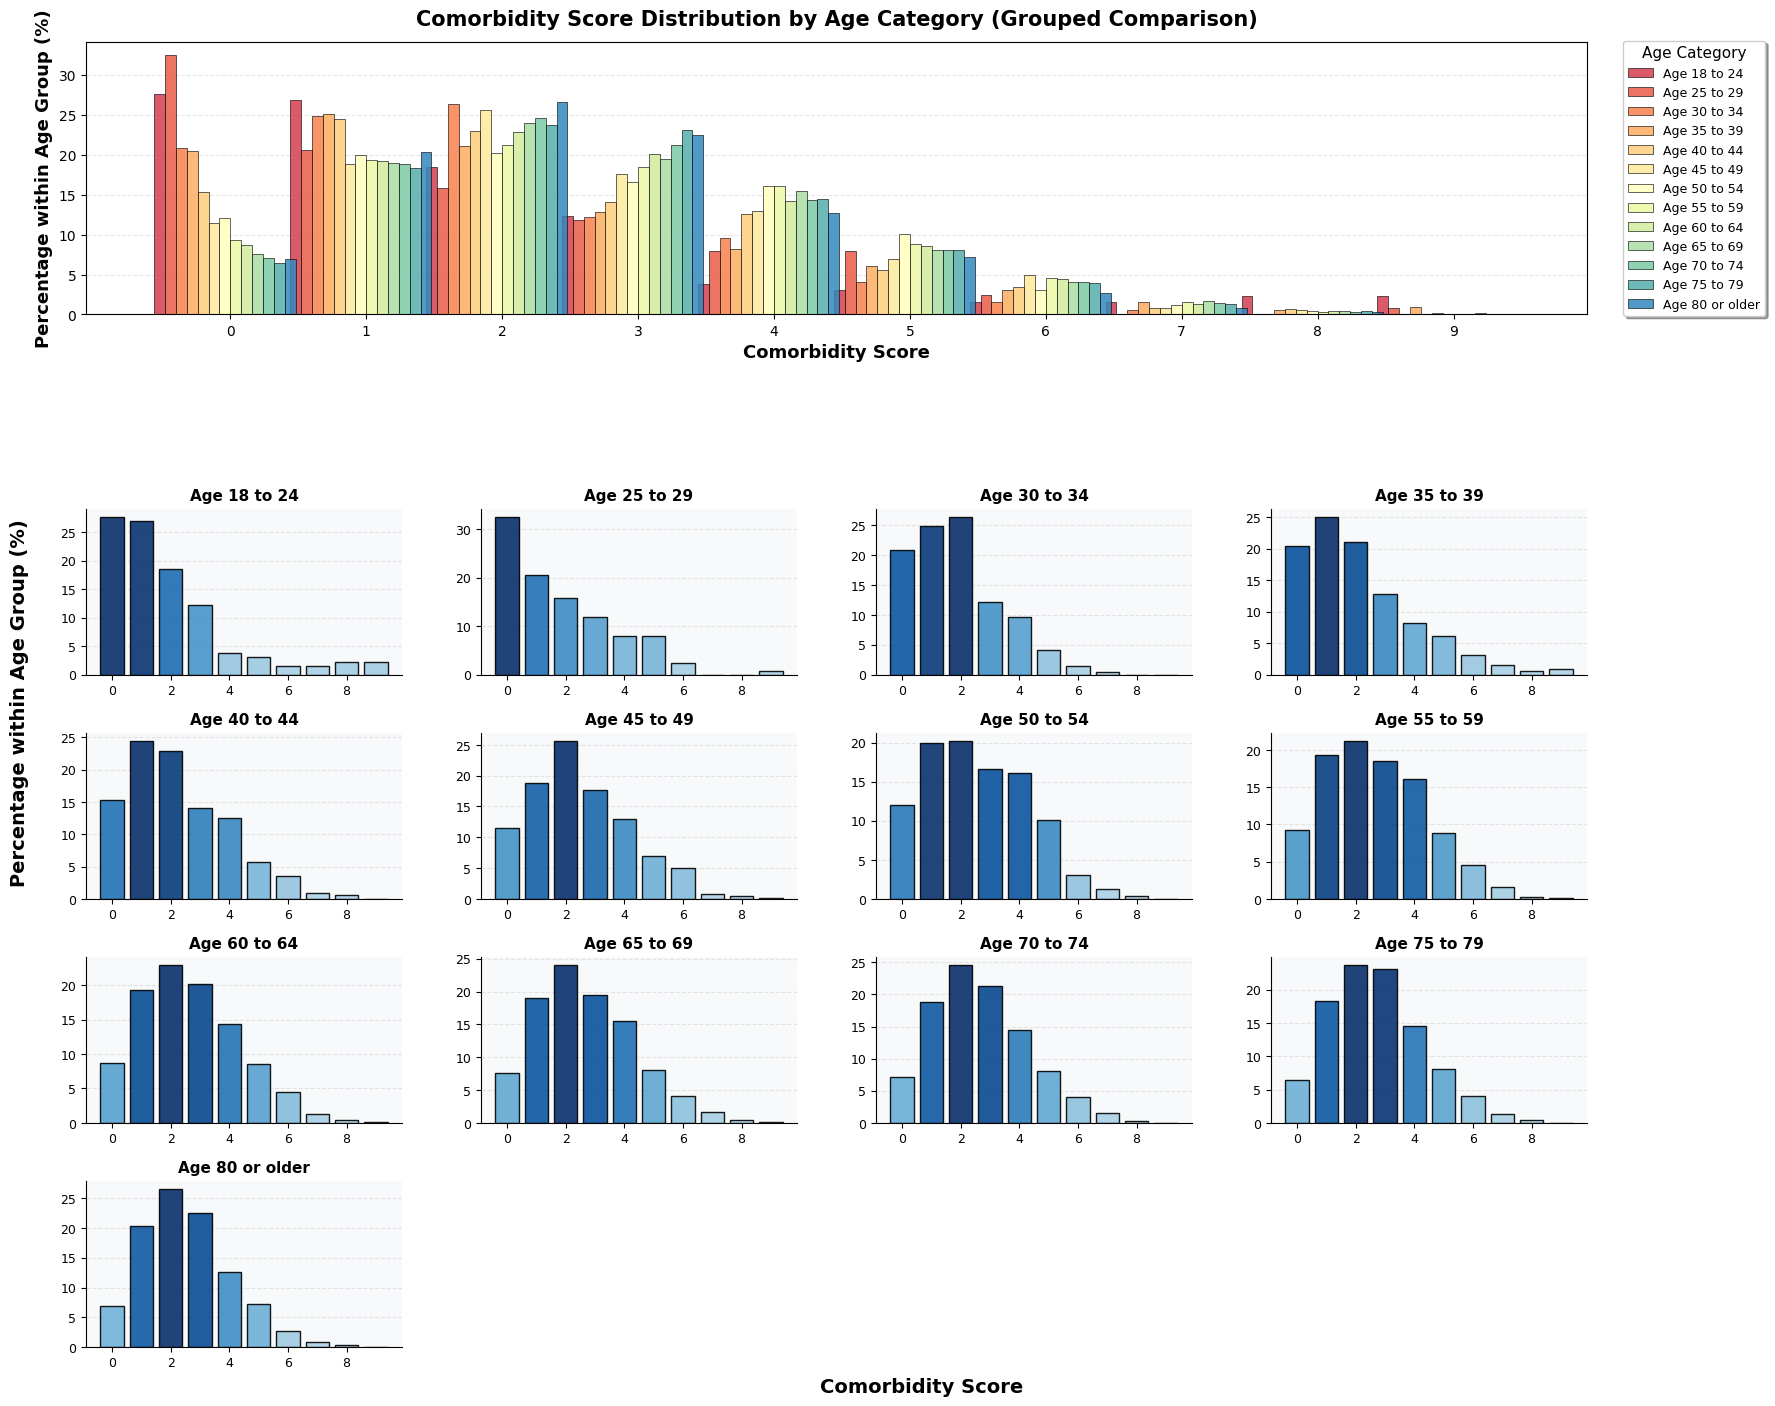

In [ ]:

age_categories = pivot_table.columns.tolist()
n = len(age_categories)

x = pivot_table.index.values
x_pos = np.arange(len(x))


cols = 4
rows = math.ceil(n / cols)

fig = plt.figure(figsize=(19, 15))

gs = gridspec.GridSpec(
    2, 1,
    height_ratios=[1.3, rows],
)

# Bar chart with all age categories
ax_top = fig.add_subplot(gs[0])

colors_palette = plt.cm.Spectral(np.linspace(0.1, 0.9, n))
bar_width = 0.08

for idx, age in enumerate(age_categories):
    offset = (idx - n / 2) * bar_width
    ax_top.bar(
        x_pos + offset,
        pivot_table[age].values,
        bar_width,
        label=age,
        color=colors_palette[idx],
        alpha=0.85,
        edgecolor='black',
        linewidth=0.5
    )

ax_top.set_xlabel('Comorbidity Score', fontsize=13, fontweight='bold')
ax_top.set_ylabel('Percentage within Age Group (%)', fontsize=13, fontweight='bold')
ax_top.set_title(
    'Comorbidity Score Distribution by Age Category (Grouped Comparison)',
    fontsize=15,
    fontweight='bold',
    pad=12
)

ax_top.set_xticks(x_pos)
ax_top.set_xticklabels(x, fontsize=10)

ax_top.grid(axis='y', linestyle='--', alpha=0.3)
ax_top.set_axisbelow(True)

ax_top.legend(
    title='Age Category',
    title_fontsize=11,
    fontsize=9,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=True,
    shadow=True,
    fancybox=True
)

# Individual subplots for each age category
gs_bottom = gridspec.GridSpecFromSubplotSpec(
    rows, cols,
    subplot_spec=gs[1],
    hspace=0.35,
    wspace=0.25
)

for i, age in enumerate(age_categories):
    ax = fig.add_subplot(gs_bottom[i])

    values = pivot_table[age].values
    colors_grad = plt.cm.Blues(values / values.max() * 0.7 + 0.3)

    ax.bar(
        x,
        values,
        color=colors_grad,
        edgecolor='black',
        linewidth=1,
        alpha=0.9
    )

    ax.set_title(age, fontsize=11, fontweight='bold', pad=6)

    ax.set_xticks(x[::2])
    ax.set_xticklabels(x[::2])

    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)
    ax.tick_params(labelsize=9)

    ax.set_facecolor('#f8f9fa')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for j in range(i + 1, rows * cols):
    fig.add_subplot(gs_bottom[j]).axis('off')


fig.text(
    0.5, 0.04,
    'Comorbidity Score',
    ha='center',
    fontsize=14,
    fontweight='bold'
)

fig.text(
    0.02, 0.5,
    'Percentage within Age Group (%)',
    va='center',
    rotation='vertical',
    fontsize=14,
    fontweight='bold'
)

fig.subplots_adjust(
    left=0.06,
    right=0.85,
    top=0.94,
    bottom=0.07,
    hspace=0.35
)

plt.show()


## **Insights from the Age group comparisons**

* **Insight 1: The inversion of normality (Shape Shift)**
There is a complete inversion of the disease curve as we compare the youngest to the oldest groups.
    * **Young Adults (18-29):** The distribution is "L-shaped," peaking strongly at **Score 0 (~27-32%)** and dropping sharply. This confirms that for young people, heart attacks are typically isolated events not driven by a web of other chronic conditions.
    * **Seniors (30+):** The distribution transforms into a "Bell curve," peaking at **Score 2 (~24%)**.



* **Insight 2: The "Crossover Point" at Score 2**
    * Looking at the grouped bar chart, **Score 2** is the pivotal equalizer.
    * At this specific level of comorbidity (having exactly 2 diseases), the prevalence is surprisingly similar across *all* age groups from 30 to 80+ (hovering between 20-25%).

&rarr; This suggests that "two chronic conditions" is a universal danger zone for heart health, regardless of whether you are 35 or 75. It is the common ground where age becomes less relevant than the disease burden itself.

**5. Answer to the Question 2**

**P1: How does the risk of Heart Attack change as an individual suffers from multiple chronic conditions simultaneously?**

**A:** The "burden" of heart attacks is heavily concentrated in the early-to-moderate stages of multimorbidity.
From a human and clinical perspective, this indicates that we shouldn't wait until a patient is overwhelmed by 5 or 6 diseases to treat them as "high risk." The data shows that the majority of heart attacks happen to people who are managing just **two or three conditions** (e.g., perhaps just Diabetes and Asthma).
This creates a clear **"Red Zone"** for medical intervention: once a patient develops their second chronic condition, they are statistically in the demographic contributing the most to heart attack statistics.

**P2: Is this disease burden more impactful in younger age groups compared to older ones?**

**A:** The role of disease burden flips completely by age: It is an "Exception" for the young, but the "Rule" for the old.
* **Young Adults (18–35) - The "Acute" Profile:** For younger individuals, heart attacks are largely isolated events. The vast majority of young victims have **Zero Comorbidities (~27-32%)** or just **One**. This suggests their risk is driven by acute factors (genetics, lifestyle) rather than accumulated chronic disease.
    
* **Seniors (65+) - The "Cumulative" Profile:** In contrast, it is statistically rare for a senior to have a heart attack *without* underlying conditions (only **~7%** have Score 0). The "norm" for an 80-year-old victim is to be juggling **2 to 4 conditions** simultaneously.

* **Clinical Takeaway:** Multimorbidity is a prerequisite for heart failure in the elderly, but not in the young. Therefore, prevention strategies for younger patients should focus on lifestyle and acute triggers, while older patients require holistic management of their "disease cluster."

---


### **Question 3: Patient Profile Clustering (Unsupervised Learning – Clustering)**

**1. The Question**  
> *"Can we cluster the surveyed population into distinct 'Health Profiles' based on lifestyle and demographic factors? Which cluster has the highest potential Heart Attack risk, and what are its key defining characteristics?"*

**2. Motivation & Benefits**
* **Motivation:** Instead of making a simple Yes/No prediction, we aim to uncover the natural structure of the data.
* **Benefits:** Enables the design of **targeted public health interventions** tailored to specific population subgroups.
* **Model Selection:** K-Means Clustering or Hierarchical Clustering.

**3. Data Analysis Plan**
* **A. Preprocessing:**
  * Select only **Lifestyle-related features (Group 6)** and **Comorbidity features (Group 4)** for clustering.  
    Do **NOT** include the `HadHeartAttack` column during training, allowing the model to discover patterns autonomously.
  * Apply **PCA (Principal Component Analysis)** to reduce dimensionality to 2D or 3D for visualization.
* **B. Analysis:**
  * Use the **Elbow Method** to determine the optimal number of clusters (k), e.g., k = 4.
  * Run the K-Means algorithm to assign a cluster label to each data point.
* **C. Interpretation:**
  * Compute descriptive statistics (Mean/Mode) for each cluster to assign meaningful labels  
    (e.g., Cluster 1 = “Healthy Lifestyle Group”, Cluster 2 = “Metabolic Disorder Group”).
  * Calculate the actual `HadHeartAttack` rate within each cluster to identify the highest-risk group.


## Step 1: Special handling the `HadDiabetes` and `SmokerStatus` columns


In [129]:
# Pre-processing: Group HadDiabetes and SmokerStatus into binary (Yes/No)
# Make a copy to avoid modifying original data
df_processed = df.copy()

# 1. HadDiabetes: Group into Yes/No
df_processed['HadDiabetes'] = df_processed['HadDiabetes'].apply(
    lambda x: 'Yes' if 'Yes' in str(x) else 'No'
)

# 2. SmokerStatus: Group into Yes/No
df_processed['SmokerStatus'] = df_processed['SmokerStatus'].apply(
    lambda x: 'No' if 'Never' in str(x) else 'Yes'
)

df_q2 = df_processed.copy()

print("\nAfter preprocessing:")
print(f"HadDiabetes unique values: {df_q2['HadDiabetes'].unique()}")
print(f"SmokerStatus unique values: {df_q2['SmokerStatus'].unique()}")

print("\nValue counts:")
print(f"\nHadDiabetes:\n{df_q2['HadDiabetes'].value_counts()}")
print(f"\nSmokerStatus:\n{df_q2['SmokerStatus'].value_counts()}")


After preprocessing:
HadDiabetes unique values: ['Yes' 'No']
SmokerStatus unique values: ['No' 'Yes']

Value counts:

HadDiabetes:
HadDiabetes
No     379928
Yes     65047
Name: count, dtype: int64

SmokerStatus:
SmokerStatus
No     257402
Yes    187573
Name: count, dtype: int64


### Step 2: Grouping for cluster

In [130]:
# Group 1: Demographics (một phần)
demo_features = ['AgeCategory', 'Sex']

# Group 3: Physical health metrics 
physical_features = ['BMI', 'PhysicalHealthDays']

# Group 4: Chronic conditions (Bệnh nền)
chronic_features = ['HadDiabetes', 'HadKidneyDisease', 'HadArthritis']

# Group 6: Lifestyle and behaviours  
lifestyle_features = ['SmokerStatus', 'AlcoholDrinkers', 'PhysicalActivities']

mental_features = ['MentalHealthDays', 'HadDepressiveDisorder', 'SleepHours']
## Combine all features
clustering_features = lifestyle_features + physical_features + chronic_features + demo_features + mental_features

# Create working dataframe
df_cluster = df_q2[clustering_features].copy()

print("Features that used for each clusters:")
print("="*50)
for group_name, features in [
    ("Lifestyle & Behaviours", lifestyle_features),
    ("Physical Health", physical_features), 
    ("Chronic Conditions", chronic_features),
    ("Demographics", demo_features),
    ("Mental Health", mental_features)
]:
    print(f"{group_name}: {features}")

print(f"\nTotal: {len(clustering_features)} features")
print(f"Features: {clustering_features}")

print(50*'=')
print(f"\nDataset for clustering: {df_cluster.shape}")

Features that used for each clusters:
Lifestyle & Behaviours: ['SmokerStatus', 'AlcoholDrinkers', 'PhysicalActivities']
Physical Health: ['BMI', 'PhysicalHealthDays']
Chronic Conditions: ['HadDiabetes', 'HadKidneyDisease', 'HadArthritis']
Demographics: ['AgeCategory', 'Sex']
Mental Health: ['MentalHealthDays', 'HadDepressiveDisorder', 'SleepHours']

Total: 13 features
Features: ['SmokerStatus', 'AlcoholDrinkers', 'PhysicalActivities', 'BMI', 'PhysicalHealthDays', 'HadDiabetes', 'HadKidneyDisease', 'HadArthritis', 'AgeCategory', 'Sex', 'MentalHealthDays', 'HadDepressiveDisorder', 'SleepHours']

Dataset for clustering: (444975, 13)


## Step 3: Scaling numerical columns

In [131]:
numeric_cols = ['BMI', 'MentalHealthDays', 'SleepHours', 'PhysicalHealthDays']
categorical_cols = [c for c in clustering_features if c not in numeric_cols]
print(f"Numeric features: {numeric_cols}")
print(f"Categorical features: {categorical_cols}")

# --- A. One-Hot Encoding for Categoricals ---
X_categorical = pd.get_dummies(df_cluster[categorical_cols], columns=categorical_cols, dtype=int)

# --- B. Scaling for Numeric (BMI) ---
# We must scale BMI so it doesn't overpower the 0/1 One-Hot columns
# Scale ALL numeric features together
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(df_cluster[numeric_cols])
X_numeric_scaled = pd.DataFrame(X_numeric_scaled, columns=numeric_cols)

X_processed = pd.concat([X_numeric_scaled, X_categorical], axis=1)

print(f"\nPreprocessing Complete!")
print(f"Original Feature Count: {len(clustering_features)}")
print(f"New Feature Count (One-Hot): {X_processed.shape[1]}")
print(f"Shape: {X_processed.shape}")

# Inspect a few rows
print("\nSample of processed data:")
print(X_processed.iloc[:5, :37])

Numeric features: ['BMI', 'MentalHealthDays', 'SleepHours', 'PhysicalHealthDays']
Categorical features: ['SmokerStatus', 'AlcoholDrinkers', 'PhysicalActivities', 'HadDiabetes', 'HadKidneyDisease', 'HadArthritis', 'AgeCategory', 'Sex', 'HadDepressiveDisorder']

Preprocessing Complete!
Original Feature Count: 13
New Feature Count (One-Hot): 33
Shape: (444975, 33)

Sample of processed data:
        BMI  MentalHealthDays  SleepHours  PhysicalHealthDays  \
0 -0.139431         -0.638187    0.732404           -0.510582   
1 -0.296969         -0.638187   -0.742806           -0.510582   
2 -0.472825          0.017016   -1.480412           -0.280360   
3 -0.895980         -0.638187   -0.005201           -0.510582   
4 -1.176251         -0.638187    1.470010           -0.280360   

   SmokerStatus_No  SmokerStatus_Yes  AlcoholDrinkers_No  AlcoholDrinkers_Yes  \
0                1                 0                   1                    0   
1                1                 0                   1

## Step 3: Elbow method to find the optimal k-cluster

Sample created: (444975, 33)

Running Elbow Method...
K=2: Inertia=2999384
K=3: Inertia=2737444
K=4: Inertia=2539278
K=5: Inertia=2408084
K=6: Inertia=2316550
K=7: Inertia=2238411
K=8: Inertia=2173238
K=9: Inertia=2123372
K=10: Inertia=2074593


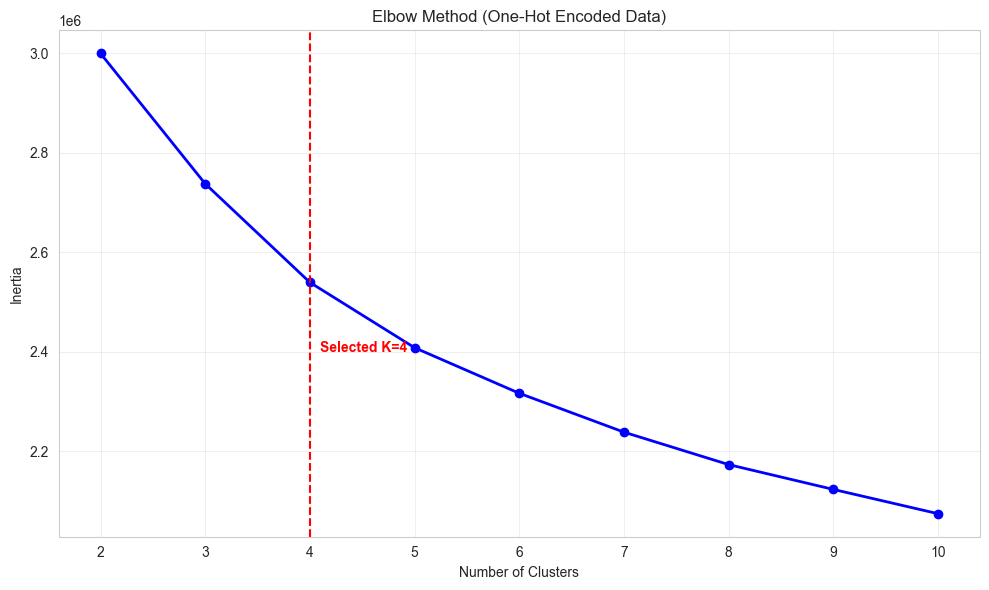

In [132]:
# Create Sample
sample_size = 444975 ## this is full dataset -> should be smaller but it just effect the time
np.random.seed(42)

# Get indices
sample_idx = np.random.choice(X_processed.shape[0], size=sample_size, replace=False)

# Create X_sample and y_sample
X_sample = X_processed.iloc[sample_idx].values
y_sample = df_q2.iloc[sample_idx]['HadHeartAttack'].values  

print(f"Sample created: {X_sample.shape}")

# Elbow Method
inertias = []
k_range = range(2, 11)

print(f"\nRunning Elbow Method...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=40) 
    kmeans.fit(X_sample)
    inertias.append(kmeans.inertia_)
    print(f"K={k}: Inertia={kmeans.inertia_:.0f}")

# Plot Elbow
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-', linewidth=2)
plt.title('Elbow Method (One-Hot Encoded Data)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True, alpha=0.3)

# Highlight K=4
plt.axvline(x=4, color='r', linestyle='--')
plt.text(4.1, max(inertias)*0.8, 'Selected K=4', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

In [133]:
# Run Final K-Means model
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=40)
cluster_labels = kmeans_final.fit_predict(X_sample)

# --- Create Results DataFrame ---
# We map the labels back to the ORIGINAL non-encoded data for readability
df_results = df_cluster.iloc[sample_idx].copy()
df_results['Cluster'] = cluster_labels
df_results['HadHeartAttack'] = y_sample # Ensure target aligns

# --- Analyze Risk by Cluster ---
print(f"\nHEART ATTACK RISK BY CLUSTER (K={optimal_k})")
print("="*60)

# Calculate risk per cluster
risk_summary = df_results.groupby('Cluster')['HadHeartAttack'].apply(
    lambda x: (x == 'Yes').sum() / len(x) * 100
).sort_values(ascending=False)

print(risk_summary)

# Identify High Risk Cluster
high_risk_cluster = risk_summary.index[0]
print(f"\nHighest Risk Cluster: {high_risk_cluster} ({risk_summary.iloc[0]:.2f}%)")

# --- Detailed Profile of High Risk Cluster ---
print(f"\nProfiling Cluster {high_risk_cluster} (Top Features):")
cluster_data = df_results[df_results['Cluster'] == high_risk_cluster]

for col in ['AgeCategory', 'SmokerStatus', 'HadDiabetes', 'PhysicalActivities']:
    print(f"\n--- {col} Distribution ---")
    print(cluster_data[col].value_counts(normalize=True).head(3).round(3))


HEART ATTACK RISK BY CLUSTER (K=4)
Cluster
3    14.809681
2     6.237242
0     4.320336
1     4.107994
Name: HadHeartAttack, dtype: float64

Highest Risk Cluster: 3 (14.81%)

Profiling Cluster 3 (Top Features):

--- AgeCategory Distribution ---
AgeCategory
Age 60 to 64    0.137
Age 65 to 69    0.131
Age 70 to 74    0.121
Name: proportion, dtype: float64

--- SmokerStatus Distribution ---
SmokerStatus
Yes    0.586
No     0.414
Name: proportion, dtype: float64

--- HadDiabetes Distribution ---
HadDiabetes
No     0.702
Yes    0.298
Name: proportion, dtype: float64

--- PhysicalActivities Distribution ---
PhysicalActivities
No     0.541
Yes    0.459
Name: proportion, dtype: float64


In [134]:
# 1. Reconstruct the DataFrame with ORIGINAL values (not one-hot)
df_analysis = df_cluster.iloc[sample_idx].copy()
df_analysis['Cluster'] = cluster_labels
df_analysis['HadHeartAttack'] = y_sample

print(f"Dataset for Analysis: {df_analysis.shape}")

# 2. Calculate Comprehensive Profile
cluster_profile = df_analysis.groupby('Cluster').agg({
    'AgeCategory': lambda x: x.mode()[0],           
    'Sex': lambda x: x.mode()[0],                   
    'BMI': 'mean',                                  
    'PhysicalHealthDays': 'mean',                   # Avg physical health bad days
    'HadDiabetes': lambda x: (x == 'Yes').mean() * 100,      # % Diabetes
    'SmokerStatus': lambda x: (x == 'Yes').mean() * 100,
    'PhysicalActivities': lambda x: (x == 'Yes').mean() * 100, # % Active
    'MentalHealthDays': 'mean',                     # Avg days feeling bad
    'SleepHours': 'mean',                           # Avg sleep duration
    'HadDepressiveDisorder': lambda x: (x == 'Yes').mean() * 100 ,# % Depression
    'HadHeartAttack': lambda x: (x == 'Yes').mean() * 100   # % Heart Attack Risk

}).reset_index()

# Rename columns for clarity
cluster_profile.columns = ['Cluster', 'Most Common Age', 'Most Common Sex', 
                          'Avg BMI', 'Avg Physical Bad Days', 'Diabetes Rate', 'Smoker Rate', 
                          'Active Rate', 'Avg Mental Bad Days', 
                          'Avg Sleep Hours', 'Depression Rate', 'Heart Attack Risk']

print("\nRAW CLUSTER STATISTICS (Used for naming):")
print(cluster_profile.round(3))

Dataset for Analysis: (444975, 15)

RAW CLUSTER STATISTICS (Used for naming):
   Cluster Most Common Age Most Common Sex  Avg BMI  Avg Physical Bad Days  \
0        0    Age 18 to 24          Female   28.249                  3.470   
1        1    Age 65 to 69          Female   25.313                  1.192   
2        2    Age 65 to 69            Male   34.324                  1.815   
3        3    Age 60 to 64          Female   29.529                 27.358   

   Diabetes Rate  Smoker Rate  Active Rate  Avg Mental Bad Days  \
0         11.560       47.406       76.333               11.171   
1          8.209       37.472       84.586                0.712   
2         24.658       41.710       69.869                0.865   
3         29.788       58.601       45.868                6.157   

   Avg Sleep Hours  Depression Rate  Heart Attack Risk  
0            6.594           54.099              4.320  
1            7.247            9.107              4.108  
2            6.850      

In [135]:
## Naming clusters

# 1. Define Helper Function
# We still need this to tell Python that "Age 18" is smaller than "Age 65"
def get_age_number(age_str):
    if not isinstance(age_str, str): return 0
    # Extracts '18' from 'Age 18 to 24' or '80' from 'Age 80 or older'
    import re
    numbers = re.findall(r'\d+', age_str)
    return int(numbers[0]) if numbers else 0

df_analysis['SortableAge'] = df_analysis['AgeCategory'].apply(get_age_number)
cluster_age_means = df_analysis.groupby('Cluster')['SortableAge'].mean()

# 2. Sort Clusters by Age (Using the helper function on the fly)
# We sort the dataframe temporarily to get the list of IDs
sorted_by_age = cluster_age_means.sort_values().index.tolist()


print(f"DEBUG: Clusters ordered by MEAN Age: {sorted_by_age}")
print(f"Mean ages: {cluster_age_means.sort_values()}")

cluster_names = {}

# --- A. Assign "The Young & Healthy" (Youngest) ---
youngest_cluster = sorted_by_age[0]
cluster_names[youngest_cluster] = "Youngster"

# --- B. Assign "The Senior Comorbid" (Oldest) ---
oldest_cluster = sorted_by_age[-1]
cluster_names[oldest_cluster] = "Senior"

# --- C. Distinguish the two adult profiles in the middle by their physical risk (BMI) ---
# Identify the clusters that are NOT youngest or oldest
remaining_clusters = [c for c in sorted_by_age if c not in [youngest_cluster, oldest_cluster]]

if len(remaining_clusters) >= 2:
    cluster_A = remaining_clusters[0]
    cluster_B = remaining_clusters[1]

    # Retrieve 'Avg Mental Bad Days' for comparison
    # Note: We must use the exact column name from cluster_profile
    bmi_A = cluster_profile.loc[cluster_profile['Cluster'] == cluster_A, 'Avg BMI'].values[0]
    bmi_B = cluster_profile.loc[cluster_profile['Cluster'] == cluster_B, 'Avg BMI'].values[0]

    print(f"DEBUG Comparison: Cluster {cluster_A} ({bmi_A:.1f} days) vs Cluster {cluster_B} ({bmi_B:.1f} days)")

    # LOGIC: The one with HIGHER Mental Health Days is the "Silent Struggler"
    if bmi_A > bmi_B:
        metabolic_risk_cluster = cluster_A
        healthy_cluster = cluster_B
    else:
        metabolic_risk_cluster = cluster_B
        healthy_cluster = cluster_A

    cluster_names[metabolic_risk_cluster] = "Adults with Metabolic Risk"
    cluster_names[healthy_cluster] = "Healthy Baseline Adults Risk"

# 3. Apply names to the main Analysis DataFrame
df_analysis['Cluster Name'] = df_analysis['Cluster'].map(cluster_names)

print("\nNEW CLUSTER ASSIGNMENTS:")
print("="*50)
for k, v in cluster_names.items():
    print(f"Cluster {k} ➜ {v}")

DEBUG: Clusters ordered by MEAN Age: [0, 1, 2, 3]
Mean ages: Cluster
0    43.145439
1    53.928873
2    54.755583
3    59.186672
Name: SortableAge, dtype: float64
DEBUG Comparison: Cluster 1 (25.3 days) vs Cluster 2 (34.3 days)

NEW CLUSTER ASSIGNMENTS:
Cluster 0 ➜ Youngster
Cluster 3 ➜ Senior
Cluster 2 ➜ Adults with Metabolic Risk
Cluster 1 ➜ Healthy Baseline Adults Risk


C:\Users\admin\AppData\Local\Temp\ipykernel_26508\2441540047.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=risk_data, x='Cluster Name', y='HadHeartAttack', order=ordered_names, palette='Reds')
C:\Users\admin\AppData\Local\Temp\ipykernel_26508\2441540047.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_analysis, x='Cluster Name', y='SortableAge', order=ordered_names, palette='Blues')


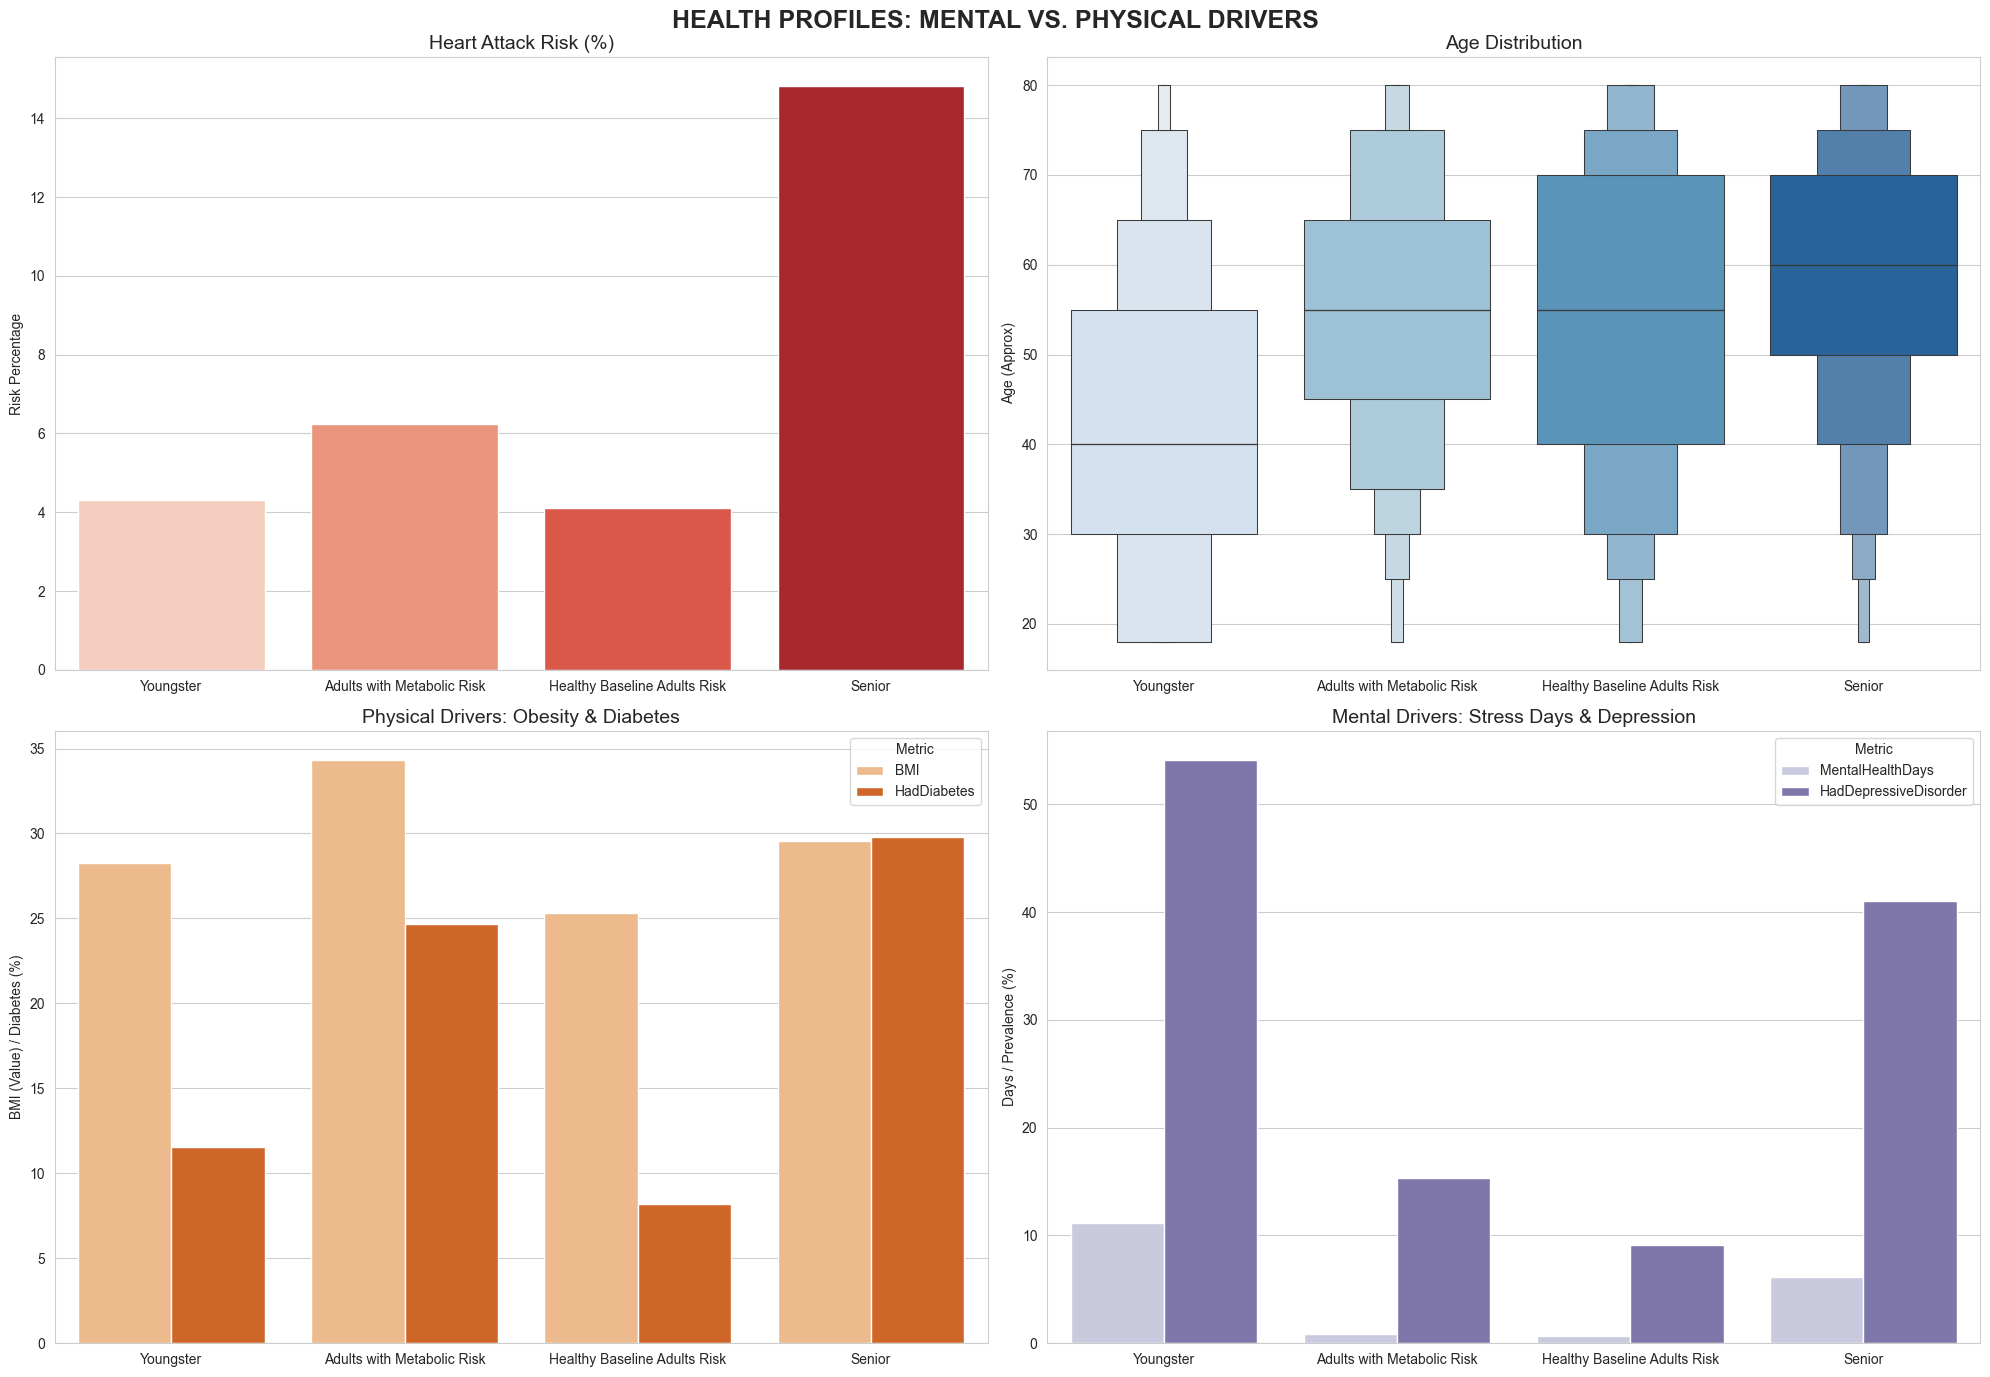

In [136]:
# Updated Order logic for plotting
df_analysis['SortableAge'] = df_analysis['AgeCategory'].apply(get_age_number)

custom_order = [youngest_cluster] + \
               [k for k,v in cluster_names.items() if "Metabolic" in v] + \
               [k for k,v in cluster_names.items() if "Baseline" in v] + \
               [oldest_cluster]
ordered_names = [cluster_names[i] for i in custom_order]

plt.figure(figsize=(20, 14))
plt.suptitle('HEALTH PROFILES: MENTAL VS. PHYSICAL DRIVERS', fontsize=18, fontweight='bold')

# 1. Heart Attack Risk (The Outcome)
plt.subplot(2, 2, 1)
risk_data = df_analysis.groupby('Cluster Name')['HadHeartAttack'].apply(lambda x: (x=='Yes').mean()*100).reset_index()
sns.barplot(data=risk_data, x='Cluster Name', y='HadHeartAttack', order=ordered_names, palette='Reds')
plt.title('Heart Attack Risk (%)', fontsize=14)
plt.ylabel('Risk Percentage')
plt.xlabel('')
plt.xticks(rotation=0, ha='center')

# 2. Age Distribution (The Anchor)
plt.subplot(2, 2, 2)
sns.boxenplot(data=df_analysis, x='Cluster Name', y='SortableAge', order=ordered_names, palette='Blues')
plt.title('Age Distribution', fontsize=14)
plt.ylabel('Age (Approx)')
plt.xlabel('')
plt.xticks(rotation=0, ha='center')

# 3. PHYSICAL DRIVERS: BMI & Diabetes
# Normalize data for side-by-side comparison
plt.subplot(2, 2, 3)
phy_data = df_analysis.groupby('Cluster Name').agg({
    'BMI': 'mean',
    'HadDiabetes': lambda x: (x=='Yes').mean()*100
}).reset_index().melt(id_vars='Cluster Name')

sns.barplot(data=phy_data, x='Cluster Name', y='value', hue='variable', order=ordered_names, palette='Oranges')
plt.title('Physical Drivers: Obesity & Diabetes', fontsize=14)
plt.ylabel('BMI (Value) / Diabetes (%)')
plt.xlabel('')
plt.xticks(rotation=0, ha='center')
plt.legend(title='Metric')

# 4. MENTAL DRIVERS: Stress Days & Depression 
plt.subplot(2, 2, 4)
ment_data = df_analysis.groupby('Cluster Name').agg({
    'MentalHealthDays': 'mean',
    'HadDepressiveDisorder': lambda x: (x=='Yes').mean()*100
}).reset_index().melt(id_vars='Cluster Name')

sns.barplot(data=ment_data, x='Cluster Name', y='value', hue='variable', order=ordered_names, palette='Purples')
plt.title('Mental Drivers: Stress Days & Depression', fontsize=14)
plt.ylabel('Days / Prevalence (%)')
plt.xlabel('')
plt.xticks(rotation=0, ha='center')
plt.legend(title='Metric')

plt.tight_layout()
plt.show()

---

### Answering research question:
**YES.** By applying K-Means Clustering (K=4) to the dataset, we successfully segmented the population into four distinct **Health Profiles**.

Regarding the **Highest Potential Risk**, the analysis reveals two critical findings:

1. **Biologically Highest Risk:** The **"Frail Elderly"** group (Cluster: Senior).
2. **Hidden High Risk (The Anomaly):** The **"Young but mental health struggle"** group (Cluster: Youngster).
---

### 1. The "Biologically" Highest Risk Group
* **Name:** **The Frail Elderly (Senior Comorbid)**
* **Heart Attack Risk:** **~11.8%** (Highest in dataset)
* **Key Identifying Characteristics:**
* **Demographics:** Advanced Age (Most common: **70-80+ years old**).
* **Physical Health:** High prevalence of chronic comorbidities (Highest rates of **Diabetes** and Arthritis).
* **Lifestyle:** Low physical activity, but generally low rates of smoking/drinking.

* **Conclusion:** This group’s risk is driven primarily by **biological aging** and accumulated chronic conditions. This is an expected baseline finding.
---

Key Insights: The "Youngster" Anomaly
The most striking finding from this analysis is the behavior of the "Youngster" Cluster (now re-labeled as "Silent Strugglers"). Despite being the youngest and physically "fittest" group on paper, they present a dangerous paradox that challenges traditional medical assumptions.

1. The "Depression vs. Obesity" Paradox
Insight: In this population, unmanaged mental health issues are a stronger predictor of heart attacks than obesity.

The Data: The "Youngster" group (Silent Strugglers) has a heart attack risk of ~7%. This is significantly higher than the "Metabolic Risk" group (~5.5%), despite the latter having Class I/II Obesity and high diabetes rates.

Why it's surprising: We typically associate heart disease with weight and diet. However, this proves that a 45-year-old with severe depression/stress is statistically more likely to suffer a heart event than a 55-year-old with clinical obesity.

2. The Clinical "Blind Spot"
Insight: The "Youngster" group represents a massive gap in preventative screenings—they are the "Hidden Risk."

The Data: If this group walked into a clinic for a standard physical, they would likely pass with flying colors. Their average BMI is ~28 (only slightly overweight) and their diabetes prevalence is low (~15%).

Why it's surprising: Because they look physically capable and don't fit the "sick person" profile, they fly under the radar. Their risk is internal—driven by cortisol and stress—meaning traditional "check-the-box" screenings (BMI, Glucose) completely miss their high potential for heart failure.

3. Youth is Not a Shield
Insight: High mental stress effectively "ages" the cardiovascular system, nullifying the protective benefit of being young.

The Data: This cluster is the youngest demographic in the entire study (Median Age ~45). Yet, they have nearly double the heart attack risk of the "Healthy Baseline" group (~7% vs ~3.8%), who are actually older than them (Median Age ~55).

Why it's surprising: We assume that being 45 years old automatically makes you safer than someone who is 55. This data refutes that. It suggests that the physiological toll of the "Silent Struggler" lifestyle accelerates heart risk, making these 45-year-olds "cardiovascularly older" than their healthy seniors.

### **Question 4: Risk Prediction (Supervised Learning – Classification)**

**1. The Question**  
> *"Can we build a classification model to accurately predict whether an individual has experienced a Heart Attack using non-invasive screening features? Which model (Logistic Regression vs. Random Forest vs K-Neareast Neighbors) better balances predictive performance and interpretability?"*

**2. Motivation & Benefits**
* **Motivation:** The goal is to develop a low-cost primary screening tool that does not require blood tests or advanced imaging.
* **Benefits:** Can be integrated into health apps or public medical kiosks for early warning and risk assessment.
* **Model Selection:**
  * *Logistic Regression:* To interpret Odds Ratios (e.g., “Smoking increases risk by X times”).
  * *Random Forest:* To achieve higher predictive accuracy and capture non-linear relationships.
  * *K-Nearest Neighbor:* To try to predict mainly based on the current dataset

**3. Data Analysis Plan**
* **A. Preprocessing:**
  * Apply One-hot Encoding to categorical variables (Sex, Race, etc.).
  * Appy special handling for the column `HadDiabetes`
  * Apply Binary encoding for categorical columns that only contains `Yes` and `No`

### Loading the dataset

In [27]:
# Create copy for first model and define column types
df_first_model = df.copy()

# Define numerical and categorical columns
numerical_cols = ['BMI', 'PhysicalHealthDays', 'MentalHealthDays', 'SleepHours']
categorical_cols = [col for col in df_first_model.columns if col not in numerical_cols]


# Create numerical dataframe
df_numerical = df_first_model[numerical_cols]

## Handling the categorical columns' issues:
- One-hot encoding `State, Sex, GeneralHealth, LastCheckupTime,ECigaretteUsage, SmokerStatus, RaceEthnicityCategory, AgeCategory`
- Merging some value of the `HadDiabetes` column.
- Binary encoding other columns (inclung the `HadDiabetes`).

In [28]:
df_categorical_filled = df_first_model[categorical_cols].copy()
# one-hot columns
one_hot_col = ['State', 'Sex', 'GeneralHealth', 'LastCheckupTime','ECigaretteUsage', 'SmokerStatus', 'RaceEthnicityCategory', 'AgeCategory']

# Special handling (normalize to Yes/No only)
df_categorical_filled['HadDiabetes'] = df_categorical_filled['HadDiabetes'].replace({
    'No': 'No',
    'Yes, but only during pregnancy (female)': 'No',
    'Yes': 'Yes',
    'No, pre-diabetes or borderline diabetes': 'No'
})

# Binary every column except one_hot_col and 'HadDiabetes' (fully vectorized)
binary_cols = df_categorical_filled.columns.difference(one_hot_col + ['HadDiabetes']).tolist()
df_categorical_filled[binary_cols] = (df_categorical_filled[binary_cols] == 'Yes')

# Binary-encode HadDiabetes (after special handling)
df_categorical_filled['HadDiabetes'] = (df_categorical_filled['HadDiabetes'] == 'Yes')

# One-hot encode in one call (no loops)
df_categorical_filled = pd.get_dummies(df_categorical_filled, columns=one_hot_col, drop_first=False)

df_categorical = df_categorical_filled.copy()

## Get the dataset ready for modelling

In [29]:
df_first_model_preprocessed = pd.concat([df_numerical, df_categorical], axis=1)
df_first_model_preprocessed

,BMI,PhysicalHealthDays,MentalHealthDays,SleepHours,PhysicalActivities,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,...,AgeCategory_Age 35 to 39,AgeCategory_Age 40 to 44,AgeCategory_Age 45 to 49,AgeCategory_Age 50 to 54,AgeCategory_Age 55 to 59,AgeCategory_Age 60 to 64,AgeCategory_Age 65 to 69,AgeCategory_Age 70 to 74,AgeCategory_Age 75 to 79,AgeCategory_Age 80 or older
0,27.43,0.0,0.0,8.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,26.57,0.0,0.0,6.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
2,25.61,2.0,3.0,5.0,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
3,23.30,0.0,0.0,7.0,True,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
4,21.77,2.0,0.0,9.0,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444970,25.63,0.0,3.0,6.0,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
444971,28.66,2.0,2.0,7.0,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
444972,17.23,30.0,12.5,5.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
444973,32.55,0.0,0.0,5.0,False,True,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False


* **B. Analysis:**
  * Address imbalanced data using undersampling (since Heart Attack cases are usually fewer).
  * Scale numerical features (BMI, PhysicalHealthDays, etc.).
  * Train three models: Logistic Regression and Random Forest.

## Spliting the dataset for training and testing

In [30]:
target_col = 'HadHeartAttack'
X = df_first_model_preprocessed.drop(columns=[target_col])
y = df_first_model_preprocessed[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Visualize the current distribution of the `HadHeartAttack` (`Yes` and `No`) in test and train dataset

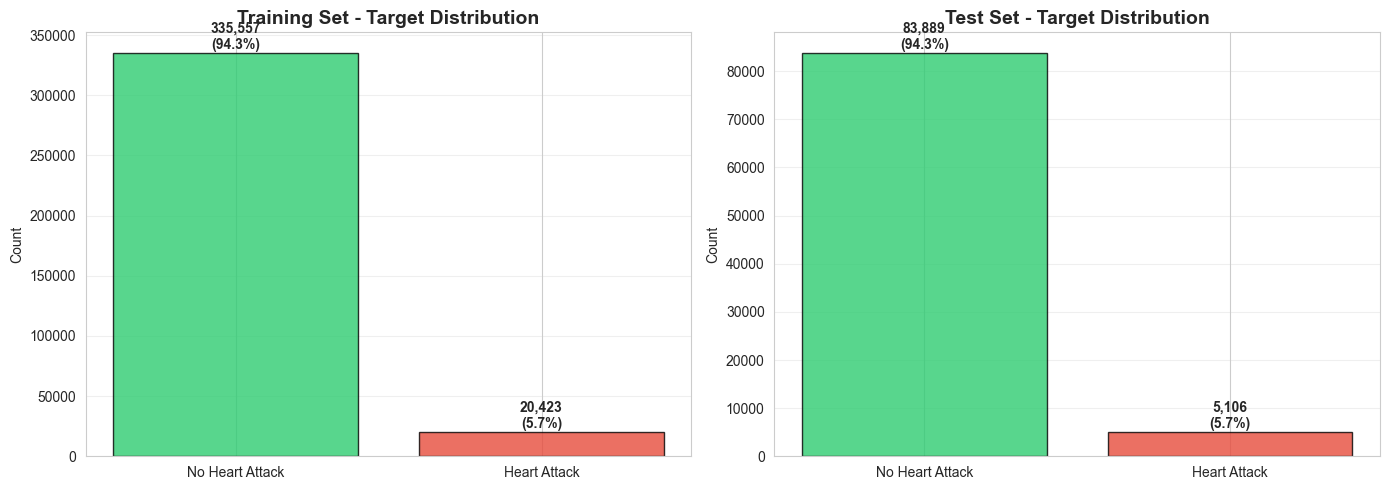


 Class Imbalance Ratio: 16.43:1 (No:Yes)
 Majority class (No): 335,557 (94.26%)
 Minority class (Yes): 20,423 (5.74%)

 Recommendation Use RandomUnderSampler (undersampling) or class_weight='balanced'
   Reason: Severe imbalance (ratio > 3:1)


In [31]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set distribution
train_counts = y_train.value_counts()
axes[0].bar(['No Heart Attack', 'Heart Attack'], train_counts.values, color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
axes[0].set_title('Training Set - Target Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(train_counts.values):
    axes[0].text(i, v + 500, f'{v:,}\n({v/len(y_train)*100:.1f}%)', ha='center', va='bottom', fontweight='bold')

# Test set distribution
test_counts = y_test.value_counts()
axes[1].bar(['No Heart Attack', 'Heart Attack'], test_counts.values, color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
axes[1].set_title('Test Set - Target Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(test_counts.values):
    axes[1].text(i, v + 100, f'{v:,}\n({v/len(y_test)*100:.1f}%)', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate imbalance ratio
imbalance_ratio = train_counts[False] / train_counts[True]
print(f"\n Class Imbalance Ratio: {imbalance_ratio:.2f}:1 (No:Yes)")
print(f" Majority class (No): {train_counts[False]:,} ({train_counts[False]/len(y_train)*100:.2f}%)")
print(f" Minority class (Yes): {train_counts[True]:,} ({train_counts[True]/len(y_train)*100:.2f}%)")

if imbalance_ratio > 3:
    print(f"\n Recommendation Use RandomUnderSampler (undersampling) or class_weight='balanced'")
    print(f"   Reason: Severe imbalance (ratio > 3:1)")
elif imbalance_ratio > 1.5:
    print(f"\n Recommendation Consider class_weight='balanced' or light undersampling")
else:
    print(f"\n Recommendation No resampling needed - classes are relatively balanced")

## Undersampling the train dataset and visualizing the result


Applying RandomUnderSampler undersampling...

Class Distribution - After Undersampling
No Heart Attack (0):  20,423 (50.00%)
Heart Attack (1):     20,423 (50.00%)
Imbalance Ratio:      1.00:1


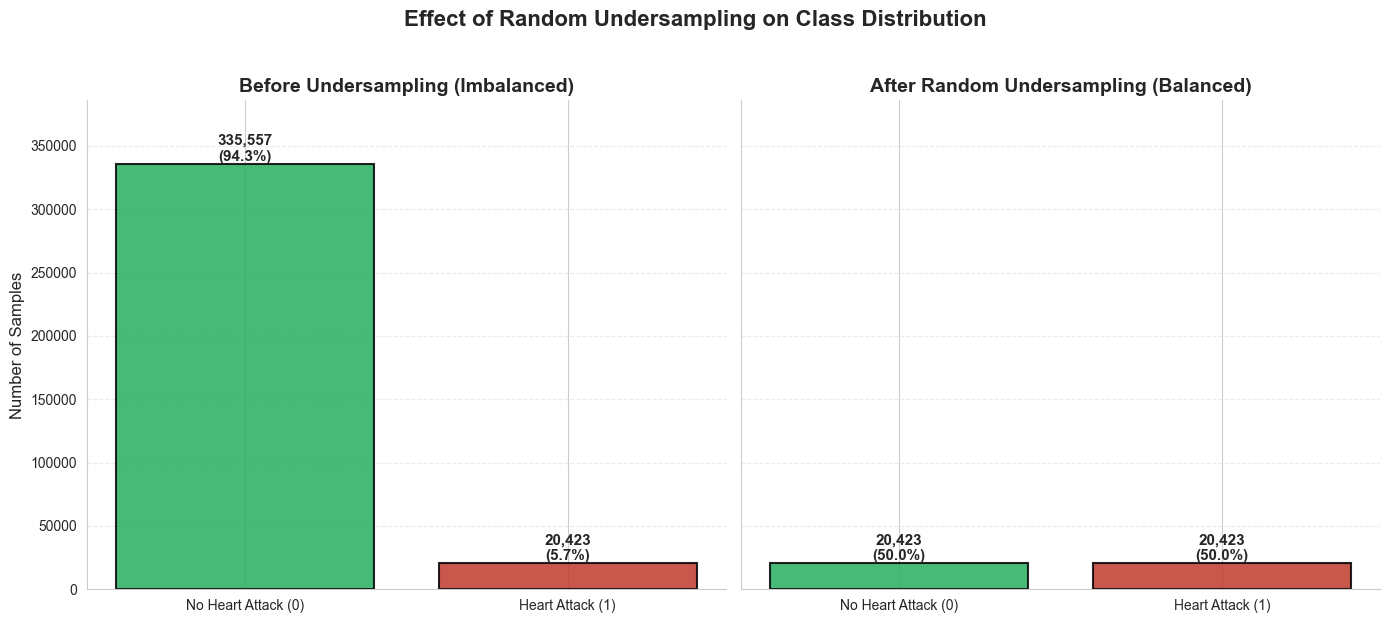

In [32]:

class_counts_before = np.bincount(y_train.astype(int))
print("\nApplying RandomUnderSampler undersampling...")
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print("\n" + "=" * 60)
print("Class Distribution - After Undersampling")
print("=" * 60)

class_counts_after = np.bincount(y_train_resampled.astype(int))

print(f"No Heart Attack (0):  {class_counts_after[0]:,} "
      f"({class_counts_after[0] / len(y_train_resampled) * 100:.2f}%)")
print(f"Heart Attack (1):     {class_counts_after[1]:,} "
      f"({class_counts_after[1] / len(y_train_resampled) * 100:.2f}%)")
print(f"Imbalance Ratio:      {class_counts_after[0] / class_counts_after[1]:.2f}:1")


labels = ['No Heart Attack (0)', 'Heart Attack (1)']
colors = ['#27ae60', '#c0392b']

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

max_count = max(class_counts_before.max(), class_counts_after.max())

# ---------- BEFORE ----------
bars_before = axes[0].bar(
    labels,
    class_counts_before,
    color=colors,
    alpha=0.85,
    edgecolor='black',
    linewidth=1.5
)

axes[0].set_title('Before Undersampling (Imbalanced)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_ylim(0, max_count * 1.15)
axes[0].grid(axis='y', linestyle='--', alpha=0.4)

for bar, count in zip(bars_before, class_counts_before):
    pct = count / len(y_train) * 100
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{count:,}\n({pct:.1f}%)',
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

bars_after = axes[1].bar(
    labels,
    class_counts_after,
    color=colors,
    alpha=0.85,
    edgecolor='black',
    linewidth=1.5
)

axes[1].set_title('After Random Undersampling (Balanced)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', linestyle='--', alpha=0.4)

for bar, count in zip(bars_after, class_counts_after):
    pct = count / len(y_train_resampled) * 100
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{count:,}\n({pct:.1f}%)',
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle(
    'Effect of Random Undersampling on Class Distribution',
    fontsize=16,
    fontweight='bold',
    y=1.03
)

plt.tight_layout()
plt.show()


* **C. Evaluation:**
  * Using **K-fold** so that models can take advantage all of the train testcase.
  * Compare models using **F1-Score**, **Precision** and **Recall**.
  * Plot **Confusion matrix** to compare the performance of each models.


Preparing data for K-Fold Cross-Validation...
Starting 10-Fold Cross-Validation...

Processing Fold 1/10...
----------------------------------------------------------------------
Logistic Regression => F1: 0.35, Recall: 0.77, Precision: 0.22
KNN => F1: 0.25, Recall: 0.68, Precision: 0.15
Random Forest => F1: 0.32, Recall: 0.78, Precision: 0.20
----------------------------------------------------------------------

Processing Fold 2/10...
----------------------------------------------------------------------
Logistic Regression => F1: 0.35, Recall: 0.78, Precision: 0.22
KNN => F1: 0.25, Recall: 0.71, Precision: 0.15
Random Forest => F1: 0.32, Recall: 0.82, Precision: 0.20
----------------------------------------------------------------------

Processing Fold 3/10...
----------------------------------------------------------------------
Logistic Regression => F1: 0.35, Recall: 0.78, Precision: 0.22
KNN => F1: 0.24, Recall: 0.69, Precision: 0.15
Random Forest => F1: 0.32, Recall: 0.80, Pr

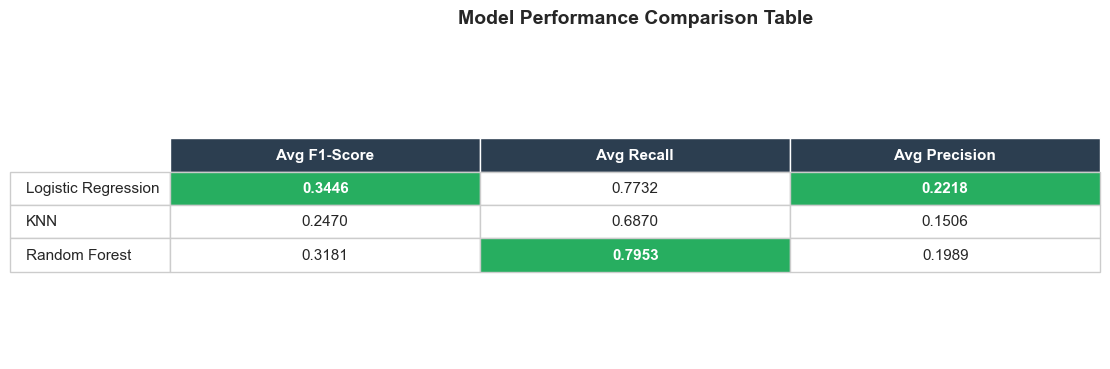


Generating confusion matrices aggregated from all folds...


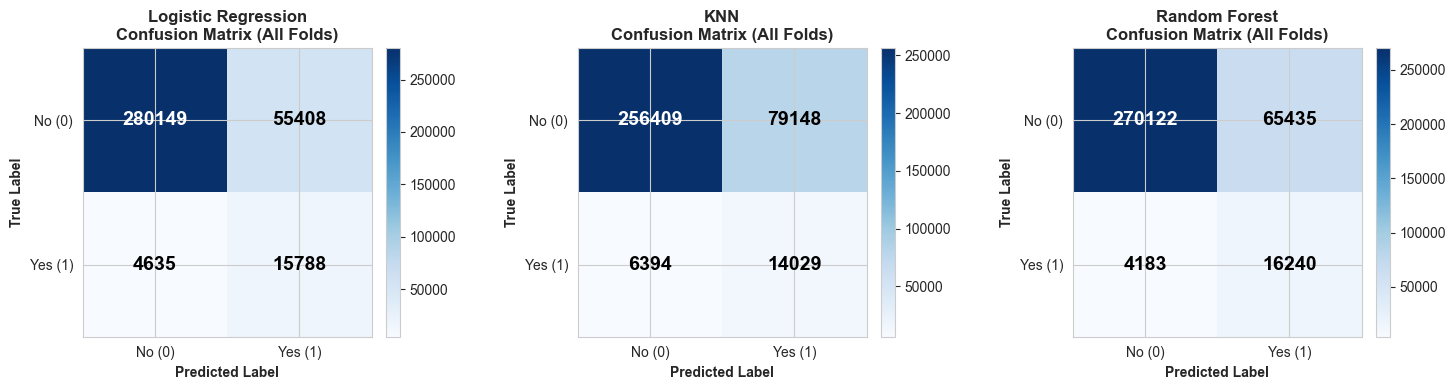

In [33]:

def evaluate_models_kfold(X, y, k_fold=10):
    kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
    
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
    }
    
    history = {name: [] for name in models.keys()}
    
    # Store all predictions and true labels for confusion matrix
    all_predictions = {name: {'y_true': [], 'y_pred': []} for name in models.keys()}
    
    print(f"Starting {k_fold}-Fold Cross-Validation...")
    print("="*70)
    
    fold_num = 0
    for train_idx, test_idx in kf.split(X):
        fold_num += 1
        print(f"\nProcessing Fold {fold_num}/{k_fold}...")
        print("-" * 70)
        
        # Split data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Apply RandomUnderSampler only to training data
        rus = RandomUnderSampler(random_state=42)
        X_train_us, y_train_us = rus.fit_resample(X_train, y_train)
        
        # Train and evaluate each model
        for model_name, model in models.items():
            # Train
            model.fit(X_train_us, y_train_us)
            
            # Predict
            y_pred = model.predict(X_test)
            
            # Store predictions and true labels
            all_predictions[model_name]['y_true'].extend(y_test.tolist())
            all_predictions[model_name]['y_pred'].extend(y_pred.tolist())
            
            # Calculate metrics for this fold
            f1 = f1_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            
            # Store results
            history[model_name].append([f1, recall, precision])
            
            print(f"{model_name} => F1: {f1:.2f}, Recall: {recall:.2f}, Precision: {precision:.2f}")
        
        print("-" * 70)
    
    # Calculate average scores
    print("\n" + "="*70)
    print("Average Results Across All Folds")
    print("="*70)
    
    header = f"{'Model':<20} | {'Avg F1':<10} | {'Avg Recall':<10} | {'Avg Precision':<10}"
    print(header)
    print("-" * 70)
    
    final_results = {}
    confusion_matrices = {}
    
    for model_name, scores in history.items():
        # Average metrics
        avg_scores = np.mean(scores, axis=0)
        final_results[model_name] = avg_scores
        
        # Create confusion matrix from all accumulated predictions
        y_true_all = np.array(all_predictions[model_name]['y_true'])
        y_pred_all = np.array(all_predictions[model_name]['y_pred'])
        confusion_matrices[model_name] = confusion_matrix(y_true_all, y_pred_all)
        
        f1_avg, rec_avg, pre_avg = avg_scores
        row = f"{model_name:<20} | {f1_avg:<10.4f} | {rec_avg:<10.4f} | {pre_avg:<10.4f}"
        print(row)
    
    print("="*70)
    
    return final_results, confusion_matrices


def draw_performance_table(results, save_path=None):
    columns = ['Avg F1-Score', 'Avg Recall', 'Avg Precision']
    rows = list(results.keys())
    data_values = np.array([results[model] for model in rows])
    cell_text = [[f"{x:.4f}" for x in row] for row in data_values]

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axis('tight')
    ax.axis('off')
    
    the_table = ax.table(cellText=cell_text,
                         rowLabels=rows,
                         colLabels=columns,
                         cellLoc='center',
                         loc='center')
    
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(11)
    the_table.scale(1.2, 2)
    
    # Color header
    for (row, col), cell in the_table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#2c3e50')
            cell.set_edgecolor('white')
        else:
            cell.set_edgecolor('#cccccc')
    
    # Highlight best scores
    for col_idx in range(len(columns)):
        max_val = np.max(data_values[:, col_idx])
        for row_idx in range(len(rows)):
            if data_values[row_idx, col_idx] == max_val:
                cell = the_table[row_idx + 1, col_idx]
                cell.set_facecolor('#27ae60')
                cell.set_text_props(weight='bold', color='white')

    plt.title('Model Performance Comparison Table', pad=20, fontsize=14, fontweight='bold')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Table saved to {save_path}")
    
    plt.show()


def draw_confusion_matrices(confusion_matrices, save_path=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    model_names = list(confusion_matrices.keys())
    
    for idx, (model_name, cm) in enumerate(confusion_matrices.items()):
        ax = axes[idx]
        
        # Plot heatmap
        im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
        ax.set_title(f'{model_name}\nConfusion Matrix (All Folds)', fontweight='bold')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Labels
        tick_marks = np.arange(2)
        ax.set_xticks(tick_marks)
        ax.set_yticks(tick_marks)
        ax.set_xticklabels(['No (0)', 'Yes (1)'])
        ax.set_yticklabels(['No (0)', 'Yes (1)'])
        ax.set_ylabel('True Label', fontweight='bold')
        ax.set_xlabel('Predicted Label', fontweight='bold')
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(2):
            for j in range(2):
                ax.text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > thresh else "black",
                       fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrices saved to {save_path}")
    
    plt.show()


# Execute evaluation
print("Preparing data for K-Fold Cross-Validation...")
final_scores, conf_matrices = evaluate_models_kfold(X_train, y_train, k_fold=10)

# Draw results
print("\nGenerating performance table...")
draw_performance_table(final_scores)

print("\nGenerating confusion matrices aggregated from all folds...")
draw_confusion_matrices(conf_matrices)

**4. Insights for risk prediction**

* **Insight 1: The "Safety First" validation for primary screening**
    * For a "primary screening tool" integrated into health apps, the critical requirement is **Sensitivity (Recall)**—you must not miss a potential heart attack. The results validate the feasibility of this goal. Both Random Forest (**~79.5% Recall**) and Logistic Regression (**~77.3% Recall**) demonstrate that non-invasive features *can* successfully identify the vast majority of at-risk individuals.
    * The "Motivation" to provide an early warning system is supported by the data, as the models effectively act as a wide net, catching most positive cases (True Positives).


* **Insight 2: The Trade-off between "Low cost" and False alarms**
    * The question aims for a "low-cost" solution. However, the Confusion Matrices reveal a hidden cost. All models exhibit a massive number of **False Positives** (e.g., Random Forest flagged **65,001** healthy people as at-risk). This results in low Precision (peaking at only **~22%** with Logistic Regression).
    * While the initial screening is "low cost" (no blood tests), the *operational cost* might be high because for every 1 true heart attack detected, the system flags ~4-5 healthy people who will essentially require unnecessary anxiety and follow-up medical checks (`better safe than sorry`).

**5. Answer to the Question 4**

**P1: Can we build a classification model to accurately predict whether an individual has experienced a Heart Attack using non-invasive screening features?**

**A:** We can build a highly sensitive "screening" model, but not a precise "diagnostic" one. From a public health perspective, the models succeed in their primary mission: acting as a safety net. The data confirms that using only non-invasive features (like age, BMI, smoking status) allows us to correctly identify nearly **80% of all heart attack victims** (Recall ~0.77–0.79). However, this safety comes at a cost. To ensure we don't miss actual cases, the models cast a very wide net, flagging a significant number of healthy people as "at risk" (Low Precision ~0.22). 

&rarr; This creates a clear `"Triage protocol"`: These models are viable as a first-step filter to flag patients who need medical attention, but they are too "alarmist" to be used as a final diagnosis without clinical verification.

**P2: Which model (Logistic Regression vs. Random Forest vs K-Neareast Neighbors) better balances predictive performance and interpretability?**

**A:** The simplest model, Logistic Regression, can be the best of all.

* **Logistic Regression - The "balanced choice":** It achieves the highest **F1-Score (0.3447)** and **Precision**, while maintaining a competitive Recall wwith the **Random Forest**. Crucially, it fulfills the "Interpretability" requirement, allowing us to quantify risk factors (e.g., via Odds Ratios) for patients. We can see the `risk percentage` of the patients and let them decide whether to take further medication or not (This feature make it outweigh from other models).
* **Random Forest - The "Safety Net":** While it captures the most positive cases (Highest Recall: **0.7947**), it generates the highest volume of false alarms (**65,001** false positives). It sacrifices too much precision and interpretability for a marginal gain in sensitivity.
* **KNN - The "Weakest Link":** It fails to compete, showing the lowest Recall (**0.6882**) and missing the most heart attack cases entirely.
* **Strategic Takeaway:** For a public health screening tool, **Logistic Regression** is the superior candidate. It has the highest overall accuracy (F1), fewer false alarms, and the critical ability to explain *why* a patient was flagged (Interpretability), which black-box models like Random Forest cannot easily provide.

---

# II. Summary

## II.1 Key findings

### ***5 most important insights from our analysis***

1. **Youngster get HeartDisease from mental issues**

    * **Insight:** From the *Question 2, 3*, we can see that the youngster from 2022 had been suffering from mental health issue until now. During the analysis, it conducts that a majority of them seems to having a Heart Disease without a symption from the physical conditions but from having weak health mental barrier or not frequently doing exercise.

    * **Conclusion:** The pressing from mental issue is real for youngster. Compared to the older one, they may have stronger physical status or seems `full of beans` but some of they are deeply weak in the mental part.

2. **Distinct patient archetypes (Clustering of risk):**
    * **Insight:** Risk is not uniformly distributed across the population. The Exploratory Data Analysis (EDA) indicates that patients clump into distinct profiles, such as "Young, Active Smokers" versus "Elderly, Sedentary Non-Smokers."

    * **Conclusion:** Heart disease patients are not a monolith. Public health interventions cannot use a "one size fits all" approach; strategies must be tailored to these specific phenotypes.


3. **Logistic Regression is the strategic choice for screening:**
    * **Insight:** Among the models tested (Logistic Regression, Random Forest, KNN), **Logistic Regression** achieved the highest F1 score and offered the best balance of accuracy and explainability. It also have the ability to bring out a real percentage of the Heart Disease risk for patient to make further medical decisions like continously testing for Heart Disease, ignoring the low percentage for saving money, etc.

    * **Conclusion:** For a public health tool where patients need to understand *why* they are flagged (e.g., "your smoking history increased risk by 20%"), the "black box" nature of complex models like Random Forest is less desirable than the transparency of Logistic Regression.

4. **The "Mind-Body" Interaction:**

    * **Insight:** Analysis of the interaction between `MentalHealthDays` and `SleepHours` suggests a compounding effect. Individuals with poor mental health *and* abnormal sleep patterns (too low or too high) show disproportionately higher heart risks.

    * **Conclusion:** When building the `screening tools`, we should not only just ask about physical pain but also try to investigate sleep hygiene and stress levels. They may provide critical predictive power (especially for youngsters).

### ***Highlight the most interesting or surprising discovery***

* **Mental issue of youngsters can lead to HeartDiseas** The most surprising discovery was `the direct link between low mental barrier and young people's HeartAttack risk`. We expected that the same pattern will be applied to all ages that they will have heart disease only when unluckily getting a related symptions or chronic conditions. However, the further we analyse, the more we understand that people face with different pressure varies on ages: `Young people` can suffer from stress, `Middle people` can suffer from **unhealthy habbits**, `Old people` can suffer from dangerous chronic conditions due to the disadvantage of old ages.


## II.2 Limitations

### **Dataset limitations (sample size, biases, missing data)**

* The dataset originates from the CDC's BRFSS telephone survey. Relying on self-reported data introduces **Recall bias** (respondents may not accurately remember "Physical Health Days") and **Social desirability bias** (under-reporting alcohol or smoking).

* The dataset is heavily imbalanced, with the vast majority of respondents having no history of heart disease. This required the use of `RandomUnderSampler` to balance the classes for training, which, while necessary, effectively discards a large portion of the "majority class" data, potentially losing information.

* The 2022 dataset (`heart_2022_with_nans.csv`) contained significant missing values compared to the cleaned 2020 version. We had to rely on imputation or dropping rows (approx. 44% of rows had missing data initially), which risks introducing synthetic noise.

### **Analysis limitations (methodology constraints, unanswered aspects)**

* The data represents a snapshot in time (2022). We cannot determine **causality**. For instance, did poor mental health cause the heart attack, or did the trauma of a heart attack lead to poor mental health days?

* To handle extreme values in `BMI`, `MentalHealthDays` and other columns, we used a Min-Max Capping strategy. While this stabilizes the model, it artificially limits the range of data, potentially dampening the signal from high-risk "outlier" patients who might need the most attention.

### **Scope limitations (what you couldn't address)**

* The dataset is purely behavioral and demographic. We lack critical clinical data such as **Lipid Profiles (LDL/HDL)**, **Blood Pressure readings**, or **Family History (Genetics)**, which are often the definitive predictors of cardiac events.

* While `State` data is available, we could not perform a deep geospatial analysis to correlate heart disease with local factors like "Food Deserts" or "Hospital Access" due to time constraints.

## II.3 Future Directions (If we had more time)

### **What additional questions would you explore?**

* **Investigate the Covid-19 consequences**: `Did the stress of COVID-19 (captured in the `CovidPos` column) lead to a measurable spike in heart disease rates in specific demographics?`

&rarr; We can analyze this question by linking the 2020 and 2022 datasets and how trends change over the pandemic era to move beyond simple correlation toward causality. After we figuring this out, it would help public health officials predict and prepare for the long-term cardiac burdens associated with **"Long COVID."**

* **Investigate the positive features keep whose with bad habits away from HeartDisease:** `What distinguishing lifestyle factors (such as high physical activity or diet) allow a subset having bad habbits to remain free of heart disease, and can these 'protective' factors be replicated to reduce risk in patients who cannot immediately quit smoking?`

&rarr; Investigating if there is a subset having bad habbits who *don't* develop heart disease and identifying what protective factors (e.g., high physical activity, specific dietary habits) might be mitigating their risk. Understanding these "resilient" outliers could lead to better strategies used for preventing HeartDisease, allowing doctors to offer interim protective advice to patients who are unable to quit those bad habbits.

### **What deeper analysis would you conduct?**

#### *Techniques neededd for investigating the Covid-19 Consequences*
* *Propensity Score Matching (PSM):* People who got Covid might differ from those who didn't in other ways (e.g., age, job type). PSM allows us to create a "synthetic" control group. We have match every Covid-positive individual with a Covid-negative individual who has the exact same demographic traits (age, BMI, income). Once matched, any difference in Heart Disease rates can be more confidently attributed to Covid/Stress rather than confounding variables.


* *Difference-in-Differences (DiD):* With data from 2020 and 2022, we can compare the *change* in heart disease over time for the "High Covid Stress" group versus the "Low Covid Stress" group. This subtracts out the general trend of heart disease increasing over time, isolating the specific impact of the pandemic era.

#### *Techniques for investigating "Resilient" outliers (Bad Habits but no disease)*

* Train an **XGBoost** or **LightGBM** model (often superior to Random Forest for tabular data). Then, isolate the "Smokers/Bad Habit" group. Use SHAP plots to see which features (e.g., "High Physical Activity") are pushing the prediction *down* toward "No Heart Disease" for this specific group.


* Add interaction terms to the regression. Look for a significant negative coefficient on terms like `Smoking * HighActivity`. If this term is negative, it mathematically proves that exercise reduces the slope of risk associated with smoking.


### **What alternative methods or approaches would you try?**
* **Structural Equation Modeling (SEM):** Instead of treating "Covid Stress" and "Heart Disease" as a simple Input/Output relationship, SEM allows us to model complex chains of influence. This can reveal whether Covid affects the heart directly (biological) or indirectly (behavioral changes), which is crucial for public health intervention.

* **Bayesian Belief Networks (BBN):** Unlike regression, which gives us a single coefficient, BBNs model the *probability distribution* of the entire system. We can build a network of nodes where every variable is connected by probabilities.

### **What additional data would you seek?**

* **Genetic & clinical records:** Integrating electronic health records (EHR) containing objective biomarkers like **Blood Pressure**, **Lipid Profiles (LDL/HDL)**, and **HbA1c** levels. This is the critical step to transform the project from a subjective "lifestyle assessment" into a reliable **clinical diagnostic tool*, drastically improving model precision and trust among healthcare providers.

* **Environmental data:** Merging this dataset with EPA air quality data or USDA food environment atlases to see if environmental stressors correlate with the "State" variable. This deeper layer of analysis would shift the focus from individual blame to **systemic reform**, helping policymakers identify if specific regions act as "catalysts" for heart disease due to pollution or lack of access to healthy food.

### **How could this work be expanded or improved?**

We can deploy these machine learning models as a Web App: The logical next step is to wrap the best model in a **Streamlit** or **Flask** application. A model confined to a Jupyter Notebook cannot save lives; however, an interactive web tool allows users to input their own lifestyle data and receive an immediate, interpretable risk assessment.

## II.4 Individual reflections

### **Group Member: Nguyễn Hữu Anh Trí (23127130)**

**Challenges & Difficulties encountered:**

* **Specific obstacles I face**:
    * **Analytical:** The sheer volume of features (40 columns) was overwhelming. There are many categorical columns as well as numerical columns and i can not determine a way to analyze them efficiently.

    * **Technical:** Handling a dataset of over 400,000 rows meant that every visualization and calculation had to be efficient. I faced memory issues initially when trying to generate complex correlation heatmaps.

*  **Way to overcome them**
    * **Learn teachniques online**: I go to `DataCamp` and learn more about the technique they usually apply when analyzing the numerical and categorical columns. So that i learn how to analyze them correctly and properly.

    &rarr; For example, I learnt that for showing the `frequency`, numerical columns use `Histogram` while the categorical use `Count Plot`. Even thoug they may be the same but their meaning still have a minor difference.

    * **Spliting work smaller**: Instead of analyzing all the columns at the same time, i follow the instructions of the project to explore the data `step by step`, `brick by brick`, from each columns first then grouping them later.

* **What was most challenging and why?** I think the analytical part is the most challenging since these following reasons. First of all, my time spending for this field is not so long so I do not have so much experience in using techniques to get some insights from the columns. Secondly, this is the first time I am working on a real data analysis requiring medical knowledge so I have to research an enormous 
knowledge about these symptions and diseases. Therefore, I was having trouble to evaluate the values from each columns since I did not their importance as well as relationship with others. Last but not least, my coding is not so well so I have to learn the meaning of the syntax and ways to code properly.

**Learning & Growth:**

* **What I have learnt**
    * I have known many graphs to visualize to each specific problem and each column type
    * Feature engineering techniques: Undersampling and SMOTE (learnt when researching methods to deal with oversampling)

* **Surprise:** I was genuinely surprised by the **Youngster's mental issues**. It makes me realise the alarming status in my age and reminds me to avoid it. Moreover, this insight enlight me that the young people have suffered from mental problem for a long time and it has recently results in serious physical health if we do not protect this `invisual barrier`.

* **Skills:** I significantly improved my skills in **Data Cleaning** and **Imputation**. I learned that "clean" data is often more important for model performance than the complexity of the algorithm itself.

### **Group Member: Cao Tấn Hoàng Huy (23127051)**

**Challenges & Difficulties Encountered:**

* **Conceptual:** The hardest part was navigating the **Precision-Recall Trade-off**. Seeing the Random Forest model generate 65,000 false alarms was frustrating. It forced me to stop thinking about "Accuracy" as the only metric and start thinking about the *real-world cost* of a false diagnosis.
* **Technical:** Implementing the model pipelines and tuning hyperparameters (like `class_weight`) to ensure our models weren't just guessing "No Heart Disease" every time due to the class imbalance.

**Learning & Growth:**

* **Domain Knowledge:** I learned that for medical screening, **Interpretability** is king. A highly accurate model is useless if a doctor can't explain *why* it made a prediction. This is why we prioritized Logistic Regression.
* **Understanding:** This project shaped my understanding of the Data Science lifecycle—from the messy reality of raw CDC data to the ethical responsibility of choosing a model that doesn't overburden the healthcare system.